# Theme Park Wait Time Analysis

This notebook combines data preprocessing, exploratory data analysis, and model creation for theme park wait time prediction.

## Part 1: Data Merging and Preprocessing

### Import Libraries and Setup

In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
# %pip install openpyxl

### Wait Time Special Codes
- 0: Attraction open (no wait)
- -1: Virtual Queue
- -2: Maintenance
- -3: Closed due to weather
- -4: Attraction closed
- 91: Over 90 minutes wait

In [2]:
# Folder with the Excel files
folder_path = "/home/ms/hfu/ML/ML_Presentation_Workspace/EU_PARK/europark_raw_files" # Corrected absolute path

# Regex to extract attraction, month, and year from filename
pattern = r'^(.*?) - Queue times in (\w+) (\d{4})\.xlsx'

# Dictionary to hold data for each attraction
attraction_data = {}

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.xlsx'):
        match = re.match(pattern, filename)
        if match:
            attraction = match.group(1).strip()
            month = match.group(2)
            year = int(match.group(3))
            file_path = os.path.join(folder_path, filename)

            # Read the file
            df = pd.read_excel(file_path)

            # Add metadata
            df['Month'] = month
            df['Year'] = year

            # Rename columns for consistency
            df.columns = ['Datetime', 'WaitTime', 'Month', 'Year']

            # Add to the attraction's list
            if attraction not in attraction_data:
                attraction_data[attraction] = []
            attraction_data[attraction].append(df)

In [3]:
# For each attraction, combine all months and save one Excel file
safe_attraction_name_list = []
save_path = '/home/ms/hfu/ML/ML_Presentation_Workspace/EU_PARK/europark_attraction_merged_dfs'
for attraction, dfs in attraction_data.items():
    combined_df = pd.concat(dfs, ignore_index=True)

    # Drop rows where Datetime is missing
    combined_df = combined_df.dropna(subset=['Datetime'])

    # Split Datetime into Date and Time using string operations
    combined_df[['Date', 'Time']] = combined_df['Datetime'].astype(str).str.strip().str.split(' ', expand=True)
    safe_attraction_name = attraction.replace('-', ' ')  # avoid file path issues # Create the output file path
    fil_safe_attraction_name = safe_attraction_name.replace(' ','_')
    safe_attraction_name_list.append(fil_safe_attraction_name)
    # print(safe_attraction_name_list)
    output_file = os.path.join(save_path, f"{fil_safe_attraction_name} - All Queue Times.xlsx")
    combined_df.to_excel(output_file, index=False)
    print(f"✅ Saved merged file for: {attraction} -> {output_file}")

✅ Saved merged file for: ARTHUR -> /home/ms/hfu/ML/ML_Presentation_Workspace/EU_PARK/europark_attraction_merged_dfs/ARTHUR - All Queue Times.xlsx


### Merge All attractions in one single excel file

In [4]:
# Folder where individual attraction Excel files are stored
folder_path = 'EU_PARK/europark_attraction_merged_dfs/'

# Get list of merged attraction files
files = [f for f in os.listdir(folder_path) if f.endswith('All Queue Times.xlsx')]
print(files)

['ARTHUR - All Queue Times.xlsx']


In [5]:
merged_df = None

for file in files:
    # Full path to the Excel file
    file_path = os.path.join(folder_path, file)
    
    # Extract attraction name from filename
    attraction = file.replace(' - All Queue Times.xlsx', '').strip()

    # Read file
    df = pd.read_excel(file_path)
    df = df.drop(columns=['Datetime'], errors='ignore')
    df.rename(columns={'WaitTime': f'{attraction}_WaitTime'}, inplace=True)

    # Merge using pandas only
    if merged_df is None:
        merged_df = df
    else:
        merged_df = pd.merge(merged_df, df, on=['Date', 'Time', 'Month', 'Year'], how='outer')

merged_df = merged_df.sort_values(by=['Date', 'Time'])

output_file = os.path.join(folder_path, 'All_Attractions_Queue_Times_By_Date_Time.csv')
merged_df.to_csv(output_file, index=False)

print(f"✅ Final merged file saved to: {output_file}")

✅ Final merged file saved to: EU_PARK/europark_attraction_merged_dfs/All_Attractions_Queue_Times_By_Date_Time.csv


In [6]:
# Define a function to report missing values
def report_missing_values(df):
    total_rows = len(df)
    missing_count = df.isna().sum()
    missing_percent = (missing_count / total_rows) * 100

    result = pd.DataFrame({
        'Missing Count': missing_count,
        'Missing %': missing_percent.round(2)
    })
    result = result.sort_values(by='Missing %', ascending=False)

    return result[result['Missing Count'] > 0]  # Only show columns with missing values

In [7]:
merged_df_dt = pd.read_csv("EU_PARK/europark_attraction_merged_dfs/All_Attractions_Queue_Times_By_Date_Time.csv", index_col=False)

# Drop rows with missing Time values
merged_df_dt = merged_df_dt.dropna(subset=['Time'])



# Check missing values
print("Missing values in merged wait time data:")
print(report_missing_values(merged_df_dt))

Missing values in merged wait time data:
Empty DataFrame
Columns: [Missing Count, Missing %]
Index: []


### Merge Weather Data (Temperature, Wind, Precipitation)

In [8]:
def merge_fn_wind_prec_temp(df_path,df_type):
    """
    Parameters:
        df_path (str): Path to folder containing Excel files.
        data_type (str): Type of data ('wind', 'prec', 'temp', etc.)
        
    Returns:
        pd.DataFrame: Combined dataframe with Month and Year columns.
    """
    files = [f for f in os.listdir(df_path) if f.endswith('.xlsx')]
    data_final = []
    for file in files:
        file_path = os.path.join(df_path, file)

        # Extract month and year from filename: 'Wind speed in March 2024.xlsx'
        if df_type == 'wind':
            name_parts = file.replace('.xlsx', '').replace('Wind speed in ', '').strip().split()
        elif df_type == 'prec':
            name_parts = file.replace('.xlsx', '').replace('Precipitation probability in ', '').strip().split()
        elif df_type == 'temp':
            name_parts = file.replace('.xlsx', '').replace('Temperatures in ', '').strip().split()
        else:
            raise ValueError(f"Unknown data_type: {df_type}")
        month = name_parts[0]
        year = name_parts[1]

        # Read the file
        df = pd.read_excel(file_path)

        # Add Month and Year columns
        df['Month'] = month
        df['Year'] = int(year)
        data_final.append(df)

    # Combine all dataframes into one
    wind_df = pd.concat(data_final, ignore_index=True)
    wind_df[['Date', 'Time']] = wind_df['date_time'].astype(str).str.strip().str.split(' ', expand=True)
    wind_df = wind_df.drop(columns=['date_time'])

    return wind_df

In [9]:
# Process Wind, Precipitation, and Temperature data
wind_loc = 'EU_PARK/wind_speed/'
final_wind_df = merge_fn_wind_prec_temp(wind_loc, df_type='wind')

precipitation_loc = '/home/ms/hfu/ML/ML_Presentation_Workspace/EU_PARK/Precipitation/'
final_prec_df = merge_fn_wind_prec_temp(precipitation_loc, df_type='prec')

temperature_loc = 'EU_PARK/Temperatures/'
final_temp_df = merge_fn_wind_prec_temp(temperature_loc, df_type='temp')

print("Wind data shape:", final_wind_df.shape)
print("Precipitation data shape:", final_prec_df.shape)
print("Temperature data shape:", final_temp_df.shape)

Wind data shape: (464598, 5)
Precipitation data shape: (464598, 5)
Temperature data shape: (464598, 5)


### Merge All Data (Wait Times, Temperature, Precipitation, Wind)

In [10]:
# Step-by-step outer merges using pandas only
merged = pd.merge(merged_df_dt, final_temp_df, on=['Month', 'Year', 'Date', 'Time'], how='outer')
merged = pd.merge(merged, final_prec_df, on=['Month', 'Year', 'Date', 'Time'], how='outer')
merged = pd.merge(merged, final_wind_df, on=['Month', 'Year', 'Date', 'Time'], how='outer')

# Optional: sort for clean structure
final_merged = merged.sort_values(by=['Year', 'Month', 'Date', 'Time']).reset_index(drop=True)

print("Final merged dataframe shape:", final_merged.shape)
print("\nMissing values in final merged data:")
print(report_missing_values(final_merged))

Final merged dataframe shape: (549604, 8)

Missing values in final merged data:
                          Missing Count  Missing %
temperature_in_celsius            85828      15.62
precipitation_in_percent          85828      15.62
wind_speed_in_kmh                 85828      15.62
ARTHUR_WaitTime                    2336       0.43
Time                                836       0.15


### Add Holiday Information

In [11]:
# Add school holiday data
school_holiday_df = pd.read_csv('/home/ms/hfu/ML/ML_Presentation_Workspace/EU_PARK/holidays/baden_wuerttemberg_school_holidays_2022_2026.csv')

# Convert both Date columns to datetime
school_holiday_df['Date'] = pd.to_datetime(school_holiday_df['Date'])
final_merged['Date'] = pd.to_datetime(final_merged['Date'], errors='coerce')

# Do a left-merge with indicator
final_merged = pd.merge(
    final_merged,
    school_holiday_df[['Date']],    # only need the Date column
    on='Date',
    how='left',
    indicator=True                  # adds a '_merge' column
)

# Create the flag column (1 if holiday, 0 otherwise)
final_merged['Is_School_Holiday'] = (final_merged['_merge'] == 'both').astype(int)

# Drop the helper '_merge' column
final_merged.drop(columns=['_merge'], inplace=True)

# Add public holiday data
public_holiday_df = pd.read_csv('/home/ms/hfu/ML/ML_Presentation_Workspace/EU_PARK/holidays/baden_wuerttemberg_public_holidays_2022_2025.csv')

# Convert Date column to datetime
public_holiday_df['Date'] = pd.to_datetime(public_holiday_df['Date'])

# Do a left-merge with indicator
final_merged = pd.merge(
    final_merged,
    public_holiday_df[['Date']],    # only need the Date column
    on='Date',
    how='left',
    indicator=True                  # adds a '_merge' column
)

# Create the flag column (1 if holiday, 0 otherwise)
final_merged['Is_Public_Holiday'] = (final_merged['_merge'] == 'both').astype(int)

# Drop the helper '_merge' column
final_merged.drop(columns=['_merge'], inplace=True)

# Save the final merged dataframe
final_merged.to_csv("final_df.csv", index=False)

print("Holiday information added and final dataframe saved to final_df.csv")

Holiday information added and final dataframe saved to final_df.csv


## Part 2: Exploratory Data Analysis and Modeling

### Load Merged Data

In [12]:
# Load the merged dataset
try:
    # Try to load the data from the CSV file
    file_path = 'final_df.csv'  # Update this path if your CSV file is located elsewhere
    final_merged = pd.read_csv(file_path)
    
    # Convert Date column to datetime if it exists
    if 'Date' in final_merged.columns:
        final_merged['Date'] = pd.to_datetime(final_merged['Date'])
    
    print(f"Data loaded successfully. Shape: {final_merged.shape}")
except FileNotFoundError:
    print(f"Error: File not found. Please check if 'final_df.csv' exists in the current directory.")
except Exception as e:
    print(f"Error loading data: {str(e)}")

Data loaded successfully. Shape: (549604, 10)


In [13]:
final_merged.columns

Index(['ARTHUR_WaitTime', 'Month', 'Year', 'Date', 'Time',
       'temperature_in_celsius', 'precipitation_in_percent',
       'wind_speed_in_kmh', 'Is_School_Holiday', 'Is_Public_Holiday'],
      dtype='object')

In [14]:
final_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549604 entries, 0 to 549603
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   ARTHUR_WaitTime           547268 non-null  float64       
 1   Month                     549604 non-null  object        
 2   Year                      549604 non-null  int64         
 3   Date                      548768 non-null  datetime64[ns]
 4   Time                      548768 non-null  object        
 5   temperature_in_celsius    463776 non-null  float64       
 6   precipitation_in_percent  463776 non-null  float64       
 7   wind_speed_in_kmh         463776 non-null  float64       
 8   Is_School_Holiday         549604 non-null  int64         
 9   Is_Public_Holiday         549604 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(2)
memory usage: 41.9+ MB


# Data Pre-processing
Adding park opening and closing hours based on the information available:
- March to November: 9:00 AM to 6:00 PM
- December-January: 11:00 AM to 7:00 PM

In [15]:
def is_park_open(row):
    # Handle month as int or string
    month = row['Month']
    if isinstance(month, str):
        month_map = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 
                     'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
        month = month_map.get(month, None) if not month.isdigit() else int(month)
    # Handle hour extraction robustly
    time_val = row['Time']
    # print(month)
    hour = None
    if isinstance(time_val, str):
        try:
            hour = int(time_val.split(':')[0])
        except Exception:
            return 0
    elif not pd.isnull(time_val):
        try:
            hour = pd.to_datetime(time_val).hour
        except Exception:
            return 0
    else:
        return 0
    # Park open logic
    if month is None:
        return 0
    if 3 <= month <= 11:
        return 1 if 9 <= hour < 19 else 0
    elif month in [12, 1]:
        # print(month)
        return 1 if 11 <= hour < 20 else 0
    else:
        return 0

final_merged['Park_Open'] = final_merged.apply(is_park_open, axis=1)
print(final_merged['Park_Open'].value_counts())

Park_Open
1    487993
0     61611
Name: count, dtype: int64


In [16]:
final_merged.columns

Index(['ARTHUR_WaitTime', 'Month', 'Year', 'Date', 'Time',
       'temperature_in_celsius', 'precipitation_in_percent',
       'wind_speed_in_kmh', 'Is_School_Holiday', 'Is_Public_Holiday',
       'Park_Open'],
      dtype='object')

# Dataset with only park open hours

In [17]:
# Create a new DataFrame with only park open hours
park_open_df = final_merged[final_merged['Park_Open'] == 1].copy()

# Optional: check the shape or preview
print(park_open_df.shape)
park_open_df.head()

(487993, 11)


,ARTHUR_WaitTime,Month,Year,Date,Time,temperature_in_celsius,precipitation_in_percent,wind_speed_in_kmh,Is_School_Holiday,Is_Public_Holiday,Park_Open
9,1.0,April,2022,2022-04-01,09:00,NaN,NaN,NaN,0,0,1
10,1.0,April,2022,2022-04-01,09:05,NaN,NaN,NaN,0,0,1
11,1.0,April,2022,2022-04-01,09:10,NaN,NaN,NaN,0,0,1
12,1.0,April,2022,2022-04-01,09:15,NaN,NaN,NaN,0,0,1
13,1.0,April,2022,2022-04-01,09:20,NaN,NaN,NaN,0,0,1


In [18]:
#save the DataFrame to a new CSV file
park_open_df.to_csv('park_open_hours.csv', index=False)

### Wait Time Analysis using Special Codes
- 0: Attraction open (no wait)
- -1: Virtual Queue
- -2: Maintenance
- -3: Closed due to weather
- -4: Attraction closed
- 91: Over 90 minutes wait

The following analysis has been performed with use of LLM.

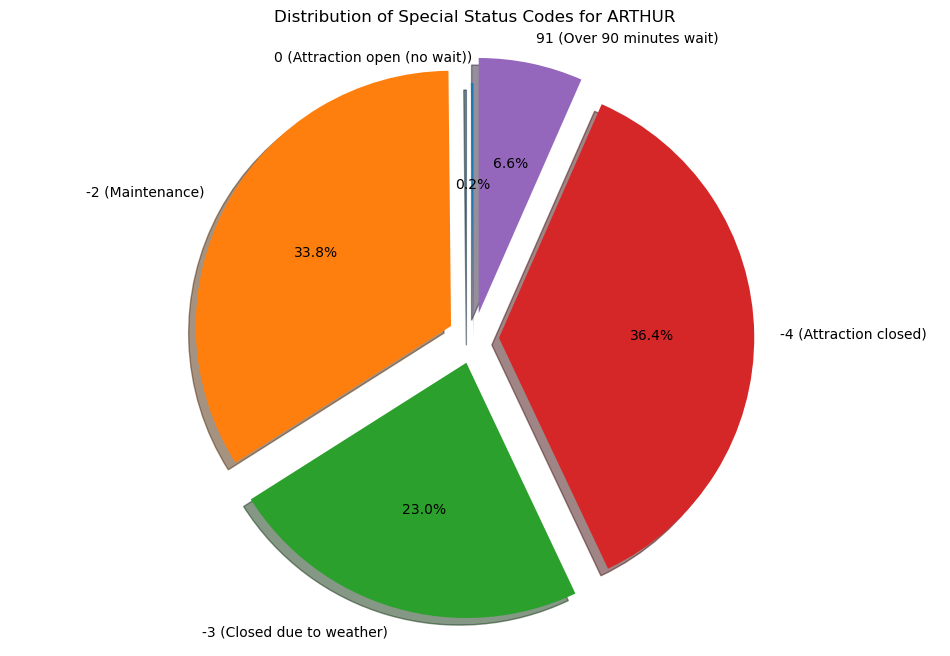

Distribution of special status codes across attractions:


,0 (Attraction open (no wait)),-1 (Virtual Queue),-2 (Maintenance),-3 (Closed due to weather),-4 (Attraction closed),91 (Over 90 minutes wait)
ARTHUR,25 (0.0%),0 (0.0%),5261 (1.1%),3582 (0.7%),5658 (1.2%),1025 (0.2%)


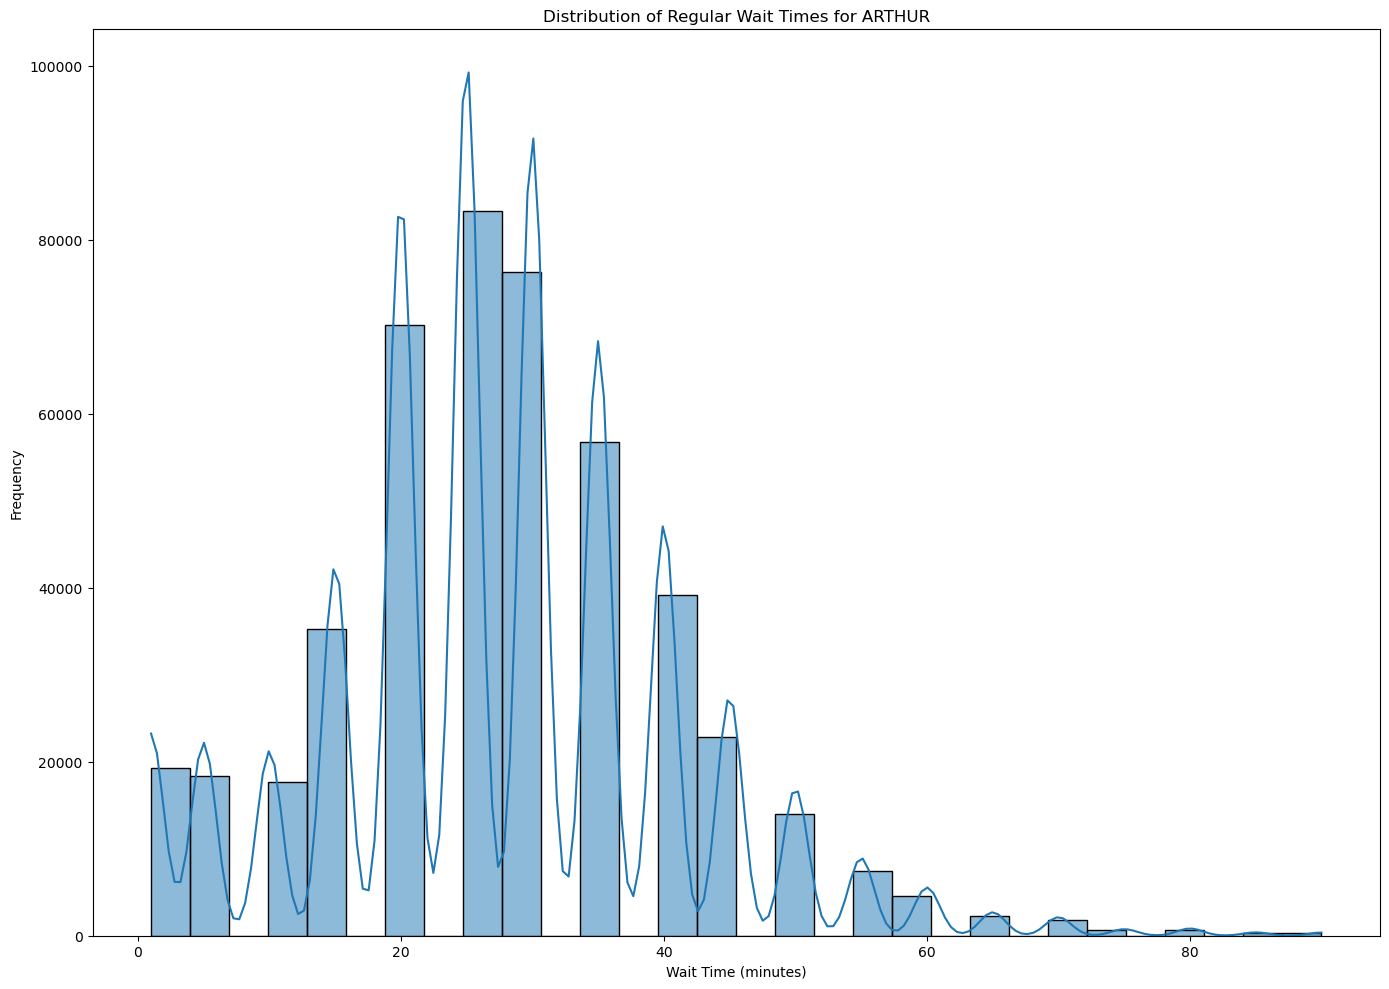

    ARTHUR_WaitTime  Month  Year       Date   Time  temperature_in_celsius  \
9               1.0  April  2022 2022-04-01  09:00                     NaN   
10              1.0  April  2022 2022-04-01  09:05                     NaN   
11              1.0  April  2022 2022-04-01  09:10                     NaN   
12              1.0  April  2022 2022-04-01  09:15                     NaN   
13              1.0  April  2022 2022-04-01  09:20                     NaN   

    precipitation_in_percent  wind_speed_in_kmh  Is_School_Holiday  \
9                        NaN                NaN                  0   
10                       NaN                NaN                  0   
11                       NaN                NaN                  0   
12                       NaN                NaN                  0   
13                       NaN                NaN                  0   

    Is_Public_Holiday  Park_Open  
9                   0          1  
10                  0          1  
11   

/tmp/ipykernel_623397/3260622213.py:95: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_time['Hour'] = pd.to_datetime(df_time['Time']).dt.hour


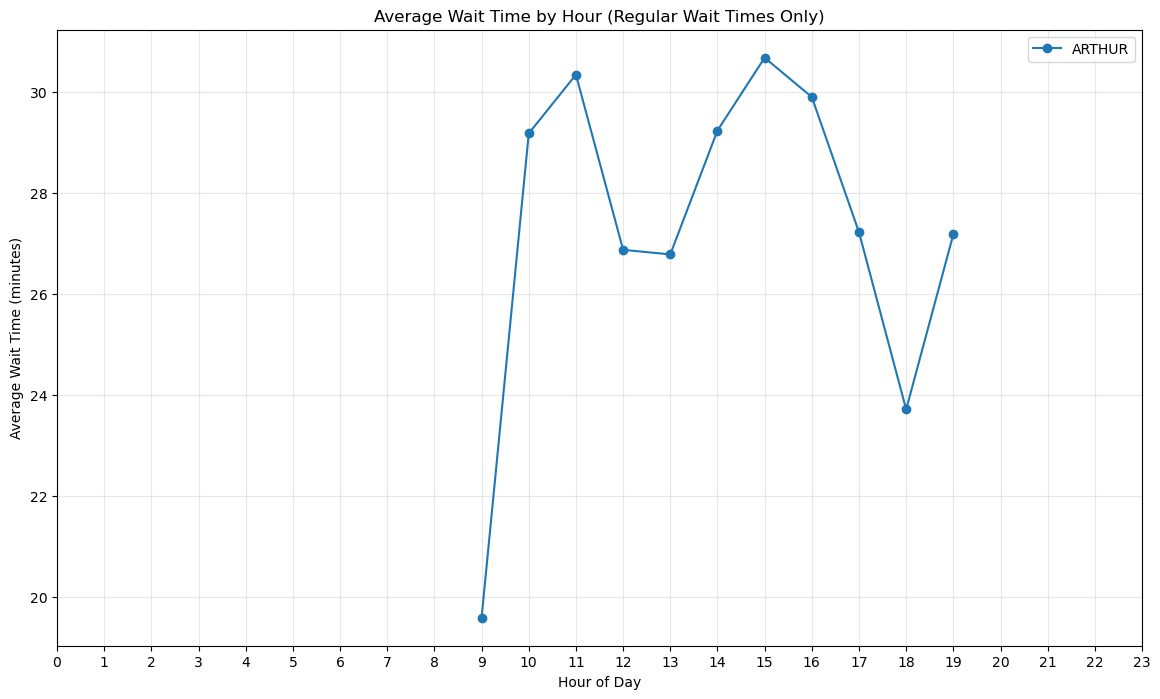

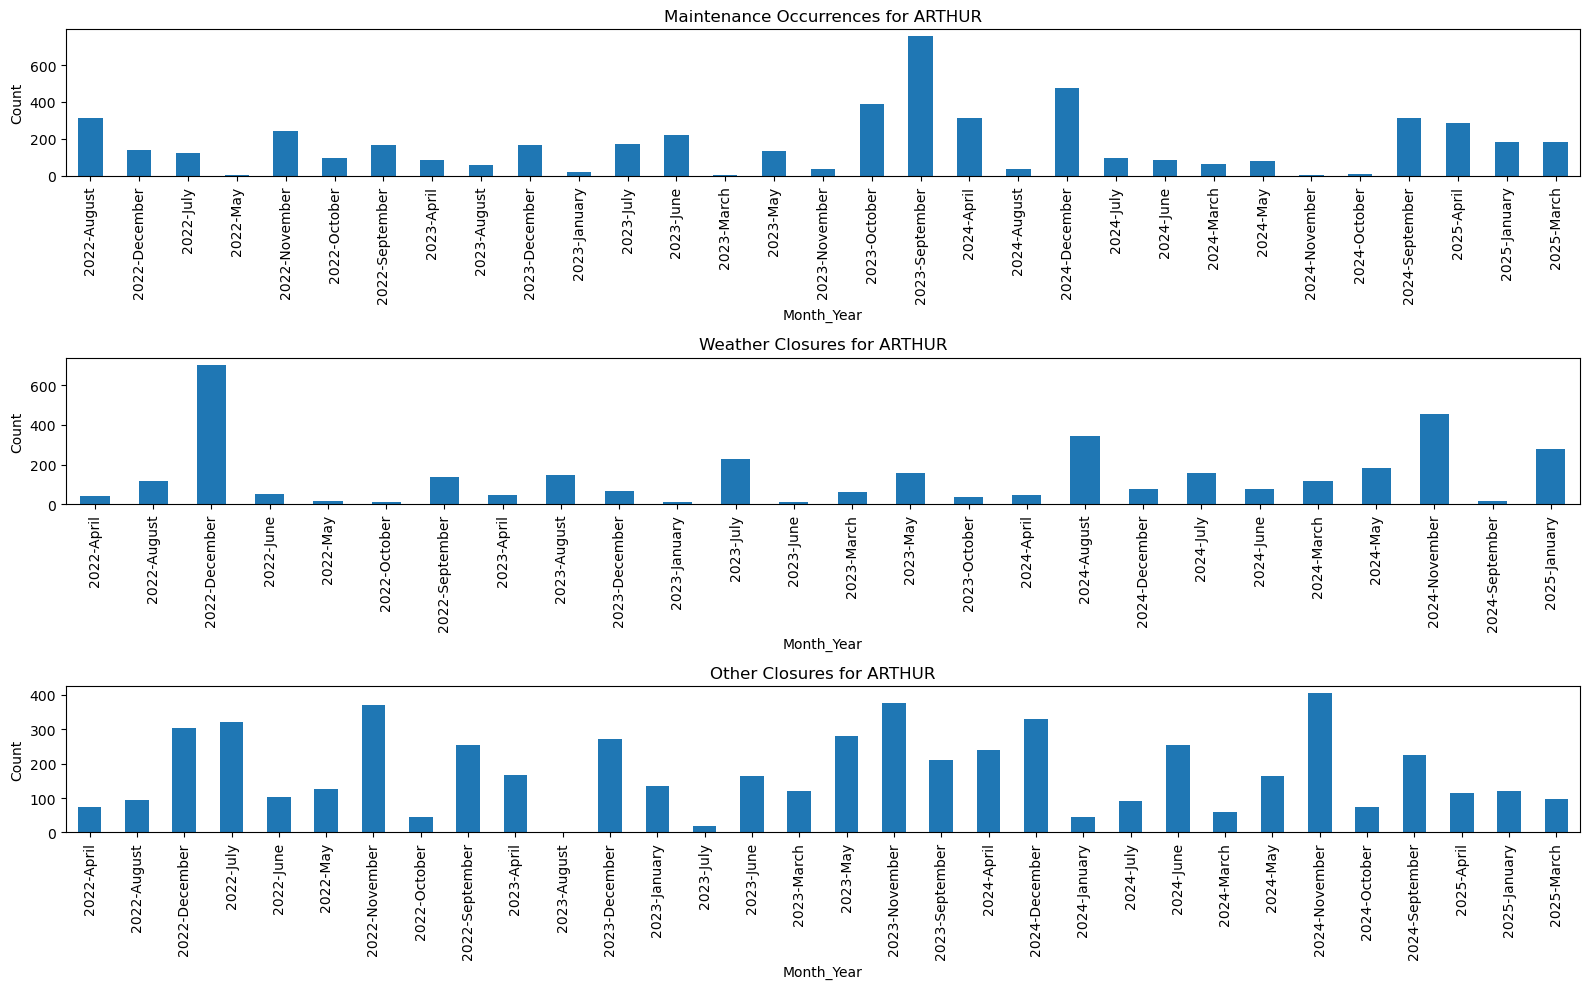

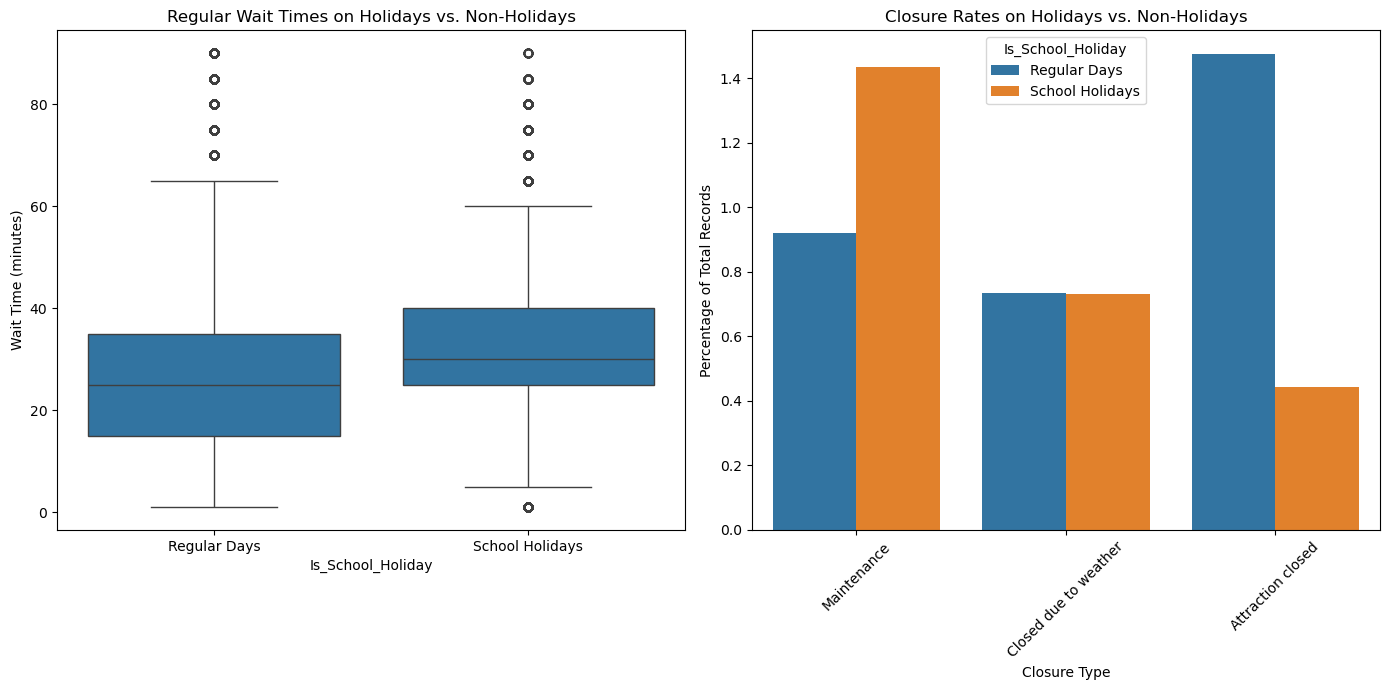

In [19]:

# Define the meaning of special codes
wait_time_codes = {
    0: "Attraction open (no wait)",
    -1: "Virtual Queue",
    -2: "Maintenance",
    -3: "Closed due to weather",
    -4: "Attraction closed",
    91: "Over 90 minutes wait"
}

# Get all columns with WaitTime in their name
wait_time_columns = [col for col in park_open_df.columns if 'WaitTime' in col]

# Function to analyze special codes across all attractions
def analyze_special_codes(df, wait_cols):
    results = {}
    
    for col in wait_cols:
        # Count occurrences of each special code
        special_codes_count = {}
        for code in wait_time_codes.keys():
            count = len(df[df[col] == code])
            if count > 0:
                special_codes_count[code] = count
        
        # Calculate percentages
        total = sum(special_codes_count.values())
        special_codes_percent = {k: (v/df[col].count())*100 for k, v in special_codes_count.items()}
        
        results[col] = {
            'counts': special_codes_count,
            'percentages': special_codes_percent
        }
    
    return results

# Analyze special codes
special_code_analysis = analyze_special_codes(park_open_df, wait_time_columns)

# Create visualization for the first attraction
plt.figure(figsize=(12, 8))

# Select the first wait time column for detailed analysis
first_col = wait_time_columns[0]
attraction_name = first_col.replace('_WaitTime', '')

# Create data for pie chart
labels = [f"{code} ({wait_time_codes[code]})" for code in special_code_analysis[first_col]['counts'].keys()]
sizes = list(special_code_analysis[first_col]['percentages'].values())
explode = [0.1 if code < 0 or code == 91 else 0 for code in special_code_analysis[first_col]['counts'].keys()]

# Plot pie chart
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title(f'Distribution of Special Status Codes for {attraction_name}')
plt.show()

# Table showing special code distributions across all attractions
special_code_table = pd.DataFrame()
for col in wait_time_columns:
    attraction = col.replace('_WaitTime', '')
    counts = special_code_analysis[col]['counts']
    percentages = special_code_analysis[col]['percentages']
    
    for code in wait_time_codes.keys():
        if code in counts:
            special_code_table.loc[attraction, f"{code} ({wait_time_codes[code]})"] = f"{counts[code]} ({percentages[code]:.1f}%)"
        else:
            special_code_table.loc[attraction, f"{code} ({wait_time_codes[code]})"] = "0 (0.0%)"

print("Distribution of special status codes across attractions:")
display(special_code_table)

# Analysis of regular wait times (positive values excluding 91)
plt.figure(figsize=(14, 10))
for i, col in enumerate(wait_time_columns[:min(len(wait_time_columns), 5)]):  # Limit to first 5 attractions
    # Filter for regular wait times (positive, excluding 91)
    wait_data = park_open_df[(park_open_df[col] > 0) & (park_open_df[col] != 91)][col]
    
    plt.subplot(min(len(wait_time_columns), 5), 1, i+1)
    sns.histplot(wait_data, kde=True, bins=30)
    plt.title(f'Distribution of Regular Wait Times for {col.replace("_WaitTime", "")}')
    plt.xlabel('Wait Time (minutes)')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Average wait times by hour of day (ignoring special codes)
if 'Time' in park_open_df.columns:
    # Extract hour from time column
    df_time = park_open_df.copy()
    print(df_time.head())
    try:
        df_time['Hour'] = pd.to_datetime(df_time['Time']).dt.hour
    except:
        df_time['Hour'] = df_time['Time'].str.split(':', expand=True)[0].astype(int)
    
    plt.figure(figsize=(14, 8))
    
    # Plot for up to 5 attractions
    for col in wait_time_columns[:min(len(wait_time_columns), 5)]:
        # Filter regular wait times
        filtered_df = df_time[(df_time[col] > 0) & (df_time[col] != 91)]
        hourly_avg = filtered_df.groupby('Hour')[col].mean().reset_index()
        
        plt.plot(hourly_avg['Hour'], hourly_avg[col], marker='o', label=col.replace('_WaitTime', ''))
    
    plt.title('Average Wait Time by Hour (Regular Wait Times Only)')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Wait Time (minutes)')
    plt.xticks(range(0, 24))
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Seasonal patterns in special codes
if 'Month' in park_open_df.columns and 'Year' in park_open_df.columns:
    plt.figure(figsize=(16, 10))
    
    # Create month-year column
    park_open_df['Month_Year'] = park_open_df['Year'].astype(str) + '-' + park_open_df['Month'].astype(str)
    
    # Focus on the first attraction
    col = wait_time_columns[0]
    
    # Track maintenance and weather closure over time
    maintenance = park_open_df[park_open_df[col] == -2].groupby('Month_Year').size()
    weather = park_open_df[park_open_df[col] == -3].groupby('Month_Year').size()
    closed = park_open_df[park_open_df[col] == -4].groupby('Month_Year').size()
    
    # Plot
    plt.subplot(3, 1, 1)
    maintenance.plot(kind='bar')
    plt.title(f'Maintenance Occurrences for {col.replace("_WaitTime", "")}')
    plt.ylabel('Count')
    
    plt.subplot(3, 1, 2)
    weather.plot(kind='bar')
    plt.title(f'Weather Closures for {col.replace("_WaitTime", "")}')
    plt.ylabel('Count')
    
    plt.subplot(3, 1, 3)
    closed.plot(kind='bar')
    plt.title(f'Other Closures for {col.replace("_WaitTime", "")}')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()

# Impact of holidays on wait times vs closure rates
if 'Is_School_Holiday' in park_open_df.columns:
    plt.figure(figsize=(14, 7))
    
    # Analyze first attraction
    col = wait_time_columns[0]
    
    # Regular wait times on holidays vs. non-holidays
    wait_holiday = park_open_df[(park_open_df[col] > 0) & (park_open_df[col] != 91) & (park_open_df['Is_School_Holiday'] == 1)][col]
    wait_regular = park_open_df[(park_open_df[col] > 0) & (park_open_df[col] != 91) & (park_open_df['Is_School_Holiday'] == 0)][col]
    
    plt.subplot(1, 2, 1)
    sns.boxplot(x='Is_School_Holiday', y=col, 
                data=park_open_df[(park_open_df[col] > 0) & (park_open_df[col] != 91)])
    plt.title(f'Regular Wait Times on Holidays vs. Non-Holidays')
    plt.xticks([0, 1], ['Regular Days', 'School Holidays'])
    plt.ylabel('Wait Time (minutes)')
    
    # Closure rates on holidays vs. non-holidays
    closure_data = []
    
    for holiday in [0, 1]:
        holiday_df = park_open_df[park_open_df['Is_School_Holiday'] == holiday]
        total = len(holiday_df)
        for code in [-2, -3, -4]:  # Maintenance, Weather, Closed
            count = len(holiday_df[holiday_df[col] == code])
            closure_data.append({
                'Is_School_Holiday': 'School Holidays' if holiday == 1 else 'Regular Days',
                'Closure Type': wait_time_codes[code],
                'Percentage': (count/total)*100 if total > 0 else 0
            })
    
    closure_df = pd.DataFrame(closure_data)
    
    plt.subplot(1, 2, 2)
    sns.barplot(x='Closure Type', y='Percentage', hue='Is_School_Holiday', data=closure_df)
    plt.title('Closure Rates on Holidays vs. Non-Holidays')
    plt.ylabel('Percentage of Total Records')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

### Basic Exploratory Data Analysis

In [20]:
# Dataset info
park_open_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 487993 entries, 9 to 549603
Data columns (total 12 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   ARTHUR_WaitTime           486583 non-null  float64       
 1   Month                     487993 non-null  object        
 2   Year                      487993 non-null  int64         
 3   Date                      487993 non-null  datetime64[ns]
 4   Time                      487993 non-null  object        
 5   temperature_in_celsius    412088 non-null  float64       
 6   precipitation_in_percent  412088 non-null  float64       
 7   wind_speed_in_kmh         412088 non-null  float64       
 8   Is_School_Holiday         487993 non-null  int64         
 9   Is_Public_Holiday         487993 non-null  int64         
 10  Park_Open                 487993 non-null  int64         
 11  Month_Year                487993 non-null  object        
dtypes: date

In [21]:

# Data preview
park_open_df.head()

,ARTHUR_WaitTime,Month,Year,Date,Time,temperature_in_celsius,precipitation_in_percent,wind_speed_in_kmh,Is_School_Holiday,Is_Public_Holiday,Park_Open,Month_Year
9,1.0,April,2022,2022-04-01,09:00,NaN,NaN,NaN,0,0,1,2022-April
10,1.0,April,2022,2022-04-01,09:05,NaN,NaN,NaN,0,0,1,2022-April
11,1.0,April,2022,2022-04-01,09:10,NaN,NaN,NaN,0,0,1,2022-April
12,1.0,April,2022,2022-04-01,09:15,NaN,NaN,NaN,0,0,1,2022-April
13,1.0,April,2022,2022-04-01,09:20,NaN,NaN,NaN,0,0,1,2022-April


In [22]:
# Dataset dimensions
park_open_df.shape


(487993, 12)

In [23]:
# Statistical summary 
park_open_df.describe()



,ARTHUR_WaitTime,Year,Date,temperature_in_celsius,precipitation_in_percent,wind_speed_in_kmh,Is_School_Holiday,Is_Public_Holiday,Park_Open
count,486583.000000,487993.000000,487993,412088.000000,412088.000000,412088.000000,487993.000000,487993.000000,487993.0
mean,26.777132,2023.229837,2023-10-26 23:01:31.543116032,15.967913,26.825071,14.188850,0.305232,0.035849,1.0
min,-4.000000,2022.000000,2022-04-01 00:00:00,-8.100000,0.000000,5.000000,0.000000,0.000000,1.0
25%,20.000000,2023.000000,2023-01-07 00:00:00,10.300000,10.000000,5.000000,0.000000,0.000000,1.0
50%,25.000000,2023.000000,2023-10-11 00:00:00,15.900000,30.000000,10.000000,0.000000,0.000000,1.0
75%,35.000000,2024.000000,2024-07-24 00:00:00,21.900000,30.000000,15.000000,1.000000,0.000000,1.0
max,91.000000,2025.000000,2025-04-30 00:00:00,36.300000,95.000000,70.000000,1.000000,1.000000,1.0
std,14.469756,0.888897,NaN,7.757448,19.414446,11.578172,0.460506,0.185913,0.0


In [24]:
# Check missing values
print("Missing values in park open data:")
print(report_missing_values(park_open_df))

Missing values in park open data:
                          Missing Count  Missing %
temperature_in_celsius            75905      15.55
precipitation_in_percent          75905      15.55
wind_speed_in_kmh                 75905      15.55
ARTHUR_WaitTime                    1410       0.29


### General Data Visualization

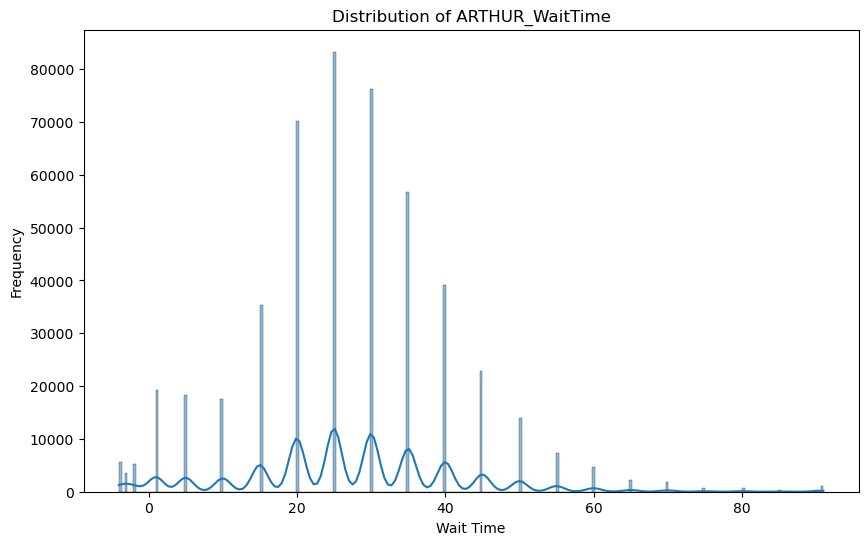

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Histogram for a wait time column
wait_time_columns = [col for col in park_open_df.columns if 'WaitTime' in col]
if wait_time_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(park_open_df[wait_time_columns[0]].dropna(), kde=True)
    plt.title(f'Distribution of {wait_time_columns[0]}')
    plt.xlabel('Wait Time')
    plt.ylabel('Frequency')
    plt.show()

# Example: Histogram for Temperature 
if 'temp_value' in park_open_df.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(park_open_df['temp_value'].dropna(), kde=True)
    plt.title('Distribution of Temperature (temp_value)')
    plt.xlabel('Temperature')
    plt.ylabel('Frequency')
    plt.show()

### Correlation Analysis

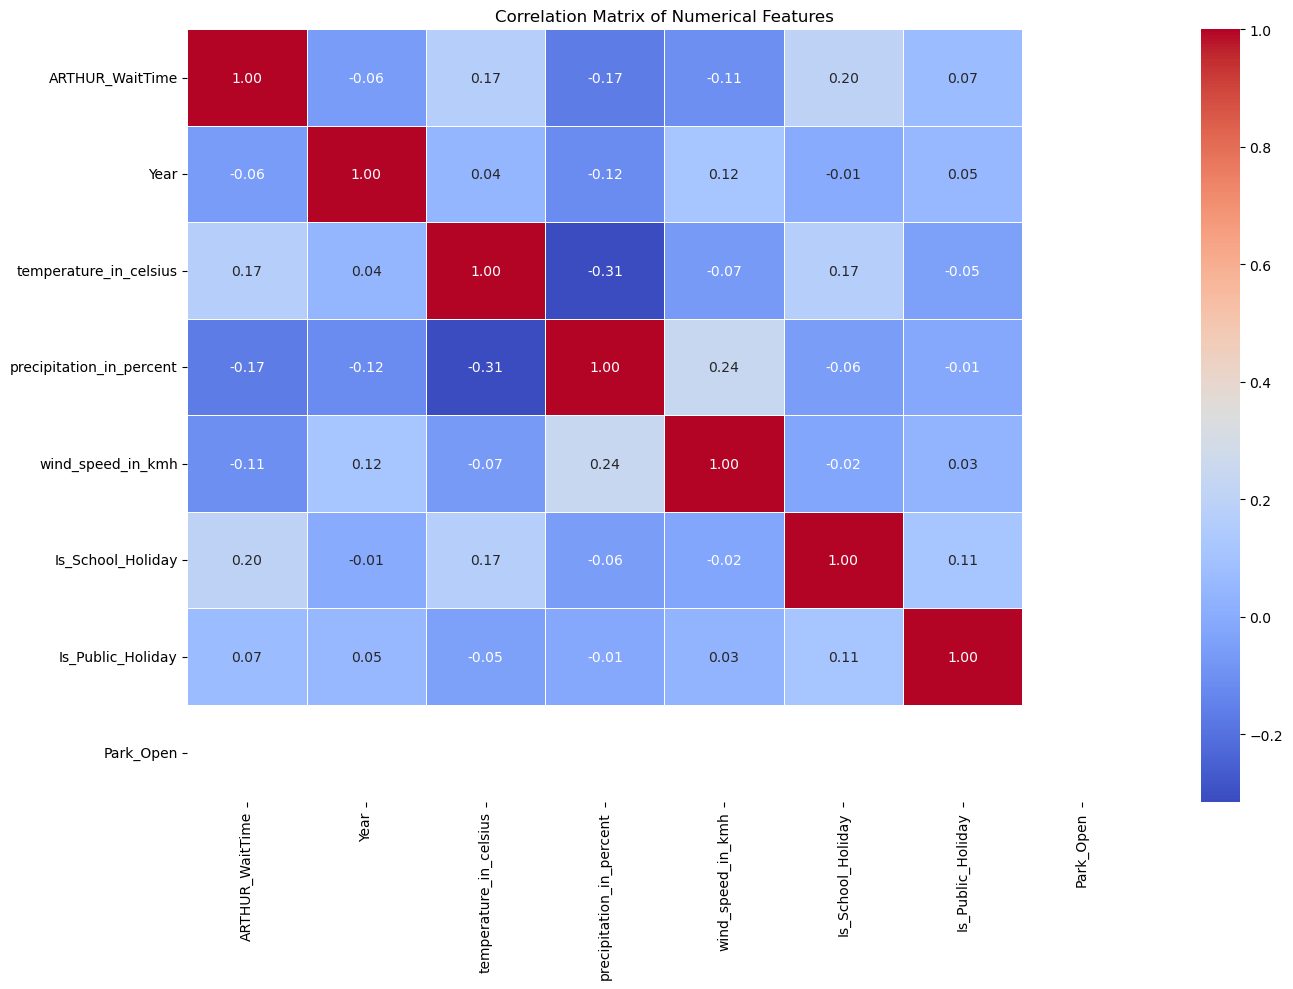

In [26]:
# Select only numerical columns for correlation analysis
numeric_cols = park_open_df.select_dtypes(include=[np.number]).columns.tolist()

# Remove unnecessary numeric columns (like index) if they exist
exclude_cols = []  # Add columns to exclude if needed
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

# Create a correlation matrix for these numeric columns
if numeric_cols:
    correlation_matrix = park_open_df[numeric_cols].corr(method='pearson', numeric_only=True)
    
    # Plot the correlation matrix
    plt.figure(figsize=(14, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Correlation Matrix of Numerical Features')
    plt.tight_layout()
    plt.show()
else:
    print("No numerical columns found for correlation analysis")

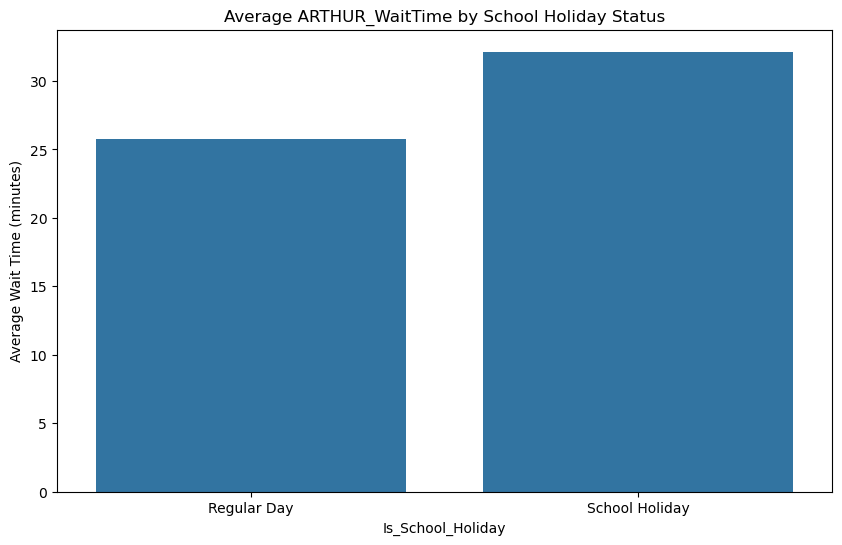

Wait time statistics by school holiday status:
  Is_School_Holiday       mean  median        std
0       Regular Day  25.727439    25.0  13.982964
1    School Holiday  32.137157    30.0  11.890392


In [27]:
# Explore relationship between wait time and holidays
wait_time_columns = [col for col in park_open_df.columns if 'WaitTime' in col]
if wait_time_columns and 'Is_School_Holiday' in park_open_df.columns:
    # Pick a representative wait time column
    wait_col = wait_time_columns[0]
    
    # Filter out values < 0 (probably maintenance or closed)
    df_filtered = park_open_df[park_open_df[wait_col] >= 0].copy()
    
    # Calculate average wait time on school holidays vs regular days
    avg_by_holiday = df_filtered.groupby('Is_School_Holiday')[wait_col].agg(['mean', 'median', 'std']).reset_index()
    avg_by_holiday['Is_School_Holiday'] = avg_by_holiday['Is_School_Holiday'].map({0: 'Regular Day', 1: 'School Holiday'})
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Is_School_Holiday', y='mean', data=avg_by_holiday)
    plt.title(f'Average {wait_col} by School Holiday Status')
    plt.ylabel('Average Wait Time (minutes)')
    plt.show()
    
    print(f"Wait time statistics by school holiday status:\n{avg_by_holiday}")

/tmp/ipykernel_623397/480812707.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_time['Hour'] = pd.to_datetime(df_time['Time']).dt.hour


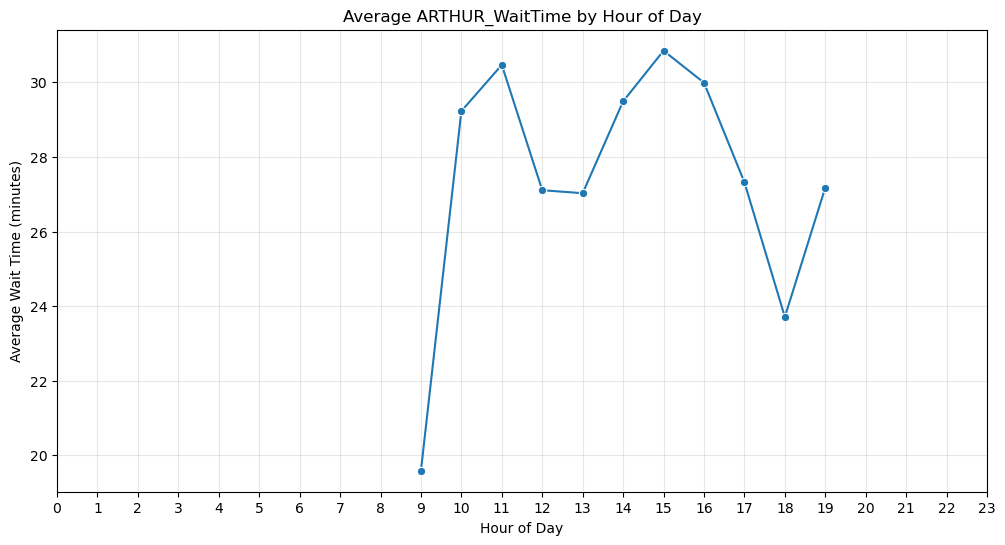

In [28]:
# Explore wait time by time of day
if wait_time_columns and 'Time' in park_open_df.columns:
    # Extract hour from time column
    df_time = park_open_df.copy()
    try:
        # Try to extract hour directly if Time is already properly formatted
        df_time['Hour'] = pd.to_datetime(df_time['Time']).dt.hour
    except:
        # If that fails, try a different approach assuming 'Time' is a string like '10:30'
        df_time['Hour'] = df_time['Time'].str.split(':', expand=True)[0].astype(int)
    
    # Filter out negative wait times
    wait_col = wait_time_columns[0]
    df_time = df_time[df_time[wait_col] >= 0]
    
    # Group by hour and calculate average wait time
    hourly_avg = df_time.groupby('Hour')[wait_col].mean().reset_index()
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Hour', y=wait_col, data=hourly_avg, marker='o')
    plt.title(f'Average {wait_col} by Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Wait Time (minutes)')
    plt.xticks(range(0, 24))
    plt.grid(True, alpha=0.3)
    plt.show()

In [29]:
# Explore the relationship between weather and wait times
if wait_time_columns and 'temp_value' in park_open_df.columns:
    wait_col = wait_time_columns[0]
    df_filtered = park_open_df[(park_open_df[wait_col] >= 0) & (~park_open_df['temp_value'].isna())].copy()
    
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='temp_value', y=wait_col, data=df_filtered, alpha=0.5)
    plt.title(f'Relationship Between Temperature and {wait_col}')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Wait Time (minutes)')
    
    # Add a trend line
    sns.regplot(x='temp_value', y=wait_col, data=df_filtered, scatter=False, color='red')
    plt.show()
    
    # Calculate correlation
    correlation = df_filtered[['temp_value', wait_col]].corr().iloc[0, 1]
    print(f"Correlation between temperature and {wait_col}: {correlation:.3f}")

## Forecasting  Linear Regression as Baseline model for later comparision

In [30]:
df = pd.read_csv('park_open_hours.csv')
target_col = 'ARTHUR_WaitTime'

In [31]:
df.isna().sum()

ARTHUR_WaitTime              1410
Month                           0
Year                            0
Date                            0
Time                            0
temperature_in_celsius      75905
precipitation_in_percent    75905
wind_speed_in_kmh           75905
Is_School_Holiday               0
Is_Public_Holiday               0
Park_Open                       0
dtype: int64

In [32]:
print("Imputing missing values for target and weather features...")
df[target_col] = df[target_col].ffill().bfill()
weather_features = ['temperature_in_celsius', 'precipitation_in_percent', 'wind_speed_in_kmh']
df[weather_features] = df[weather_features].ffill().bfill()

Imputing missing values for target and weather features...


In [33]:
df.isna().sum()


ARTHUR_WaitTime             0
Month                       0
Year                        0
Date                        0
Time                        0
temperature_in_celsius      0
precipitation_in_percent    0
wind_speed_in_kmh           0
Is_School_Holiday           0
Is_Public_Holiday           0
Park_Open                   0
dtype: int64

In [34]:
col_to_drop = ['Date', 'Time', 'ARTHUR_WaitTime']
dummy_col = ['Month']

In [35]:
y = df[target_col]
X_preproc = df.drop(columns=col_to_drop)

# Using pd.get_dummies is a straightforward way to one-hot encode
X = pd.get_dummies(X_preproc, columns=dummy_col, drop_first=True)

In [36]:
X

,Year,temperature_in_celsius,precipitation_in_percent,wind_speed_in_kmh,Is_School_Holiday,Is_Public_Holiday,Park_Open,Month_August,Month_December,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September
0,2022,4.6,40.0,10.0,0,0,1,False,False,False,False,False,False,False,False,False,False
1,2022,4.6,40.0,10.0,0,0,1,False,False,False,False,False,False,False,False,False,False
2,2022,4.6,40.0,10.0,0,0,1,False,False,False,False,False,False,False,False,False,False
3,2022,4.6,40.0,10.0,0,0,1,False,False,False,False,False,False,False,False,False,False
4,2022,4.6,40.0,10.0,0,0,1,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487988,2025,11.9,10.0,15.0,0,0,1,False,False,False,False,False,True,False,False,False,False
487989,2025,11.9,10.0,15.0,0,0,1,False,False,False,False,False,True,False,False,False,False
487990,2025,11.9,10.0,15.0,0,0,1,False,False,False,False,False,True,False,False,False,False
487991,2025,11.9,10.0,15.0,0,0,1,False,False,False,False,False,True,False,False,False,False


In [37]:
y.isna().sum()

0

In [38]:
test_size = 0.3  # Using 50% for testing as specified
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Save the indices for later reference
train_indices = X_train.index
test_indices = X_test.index

# 2. Handle missing values in features (impute with column mean)
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_train.mean())  # Use train mean for test set

# 3. Model Initialization
model = LinearRegression()

# 3. Model Training
model.fit(X_train, y_train)

# 4. Prediction of Differences
y_pred = model.predict(X_test)

In [39]:
y_pred

array([27.92501449, 27.92501449, 27.92501449, ..., 12.59395566,
       12.59395566, 12.59395566])

Mean Absolute Error (MAE): 10.1470
                     Feature   Coefficient  Abs_Coefficient
14            Month_November -1.207178e+01     1.207178e+01
12               Month_March -8.842562e+00     8.842562e+00
4          Is_School_Holiday  8.747400e+00     8.747400e+00
11                Month_June -7.807296e+00     7.807296e+00
16           Month_September -7.635685e+00     7.635685e+00
15             Month_October  7.223530e+00     7.223530e+00
8             Month_December -5.712435e+00     5.712435e+00
7               Month_August -5.260236e+00     5.260236e+00
9              Month_January -4.179379e+00     4.179379e+00
10                Month_July -4.167925e+00     4.167925e+00
0                       Year -3.615244e+00     3.615244e+00
13                 Month_May -5.305186e-01     5.305186e-01
5          Is_Public_Holiday  3.099067e-01     3.099067e-01
1     temperature_in_celsius  8.223394e-02     8.223394e-02
2   precipitation_in_percent -8.180678e-02     8.180678e-02
3    

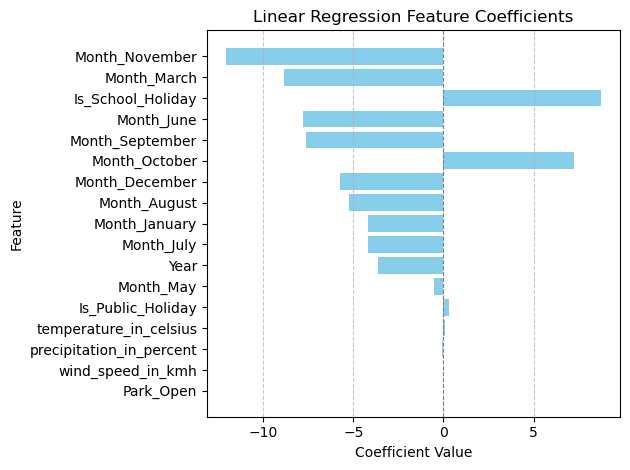

In [40]:
# Calculate and print MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# --- 3. Get the coefficients ---
# For Linear Regression, coefficients are in the 'coef_' attribute
feature_coefficients = model.coef_

# --- 4. Create a DataFrame for readability and sort ---
# X.columns gives you the names of your features
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': feature_coefficients
})

# Sort by the absolute value of the coefficient to see the strongest relationships
# (since a negative coefficient is just as 'important' in terms of magnitude)
features_df['Abs_Coefficient'] = abs(features_df['Coefficient'])
features_df = features_df.sort_values(by='Abs_Coefficient', ascending=False)

print(features_df)

plt.barh(features_df['Feature'], features_df['Coefficient'], color='skyblue')

plt.xlabel("Coefficient Value") # Changed label from "Importance"
plt.ylabel("Feature")
plt.title("Linear Regression Feature Coefficients") # Changed title
plt.gca().invert_yaxis() # To have the most impactful feature (by magnitude) at the top

# Add a vertical line at 0 for better visualization of positive/negative coefficients
plt.axvline(x=0, color='grey', linestyle='--', linewidth=0.8)

plt.grid(axis='x', linestyle='--', alpha=0.7) # Add a grid for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

Key Takeaways and Further Considerations:
Dominance of Months and School Holidays: Your model suggests that seasonal effects (months) and whether it's a school holiday are by far the most significant drivers of your target variable.
Specific Monthly Patterns: Pay close attention to which months have positive vs. negative coefficients. It seems like October has a positive impact, while most other specific months (November, March, June, September, December, August, January, July, May) have a negative impact compared to the reference category.
Limited Impact of Weather Variables: temperature_in_celsius, precipitation_in_percent, and wind_speed_in_kmh have very small coefficients, suggesting they have a minimal linear impact on the target variable.
Downward Trend Over Time: The negative coefficient for Year suggests a general decline in the target variable's value over time.
Park_Open Redundancy: The Park_Open feature seems almost entirely useless in this linear model. If your dataset only contains rows where the park is open (i.e., Park_Open is always 1), then it would essentially be absorbed into the intercept and have a near-zero coefficient, as it's not providing any differentiating information. If it's a binary variable (0 or 1) and there are instances where the park is closed (0), then its near-zero coefficient still indicates very little linear impact.
One-Hot Encoding Context: Since you have Month_November, Month_March, etc., it implies you've used one-hot encoding for a 'Month' categorical variable. One month was likely dropped as a reference category to avoid multicollinearity. The coefficients for the other months are interpreted relative to this dropped reference month.
Correlation vs. Causation: Remember that linear regression coefficients show correlation, not necessarily causation.
Feature Scaling: If your numerical features (like temperature, precipitation, wind speed) were not scaled before training the model, it's harder to directly compare their coefficients' magnitudes to those of the one-hot encoded month features. However, even without scaling, the very small absolute values for weather variables still suggest minor impact compared to the month/holiday features. If they were scaled, their small coefficients would be even more definitive indicators of low importance.

## Forecasting using Differencing with Linear Regression

This approach aims to forecast the change in waiting times instead of their absolute
values. By differencing the time series, seasonalities and trends can be removed, often
making the series more stationary and easier to model with simpler algorithms like
Linear Regression. The final prediction is then reconstructed by adding the predicted
difference to the last known actual value.

In [41]:


# Select the main attraction wait time for forecasting
wait_time_columns = [col for col in park_open_df.columns if 'WaitTime' in col]
if not wait_time_columns:
    raise ValueError("No wait time columns found in the dataset")

# For this example, we'll use the first wait time column (ARTHUR_WaitTime)
target_column = wait_time_columns[0]
print(f"Selected target column for forecasting: {target_column}")

# Phase 1: Data Preparation and Feature Engineering
# ------------------------------------------------

# 1. Initial preprocessing
# Create a copy to avoid modifying the original dataframe
df_forecast = park_open_df.copy()

# Convert Date to datetime if it's not already
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

# Create a DateTime column combining Date and Time
df_forecast['DateTime'] = pd.to_datetime(df_forecast['Date'].astype(str) + ' ' + df_forecast['Time'])

# Sort by DateTime to ensure chronological order
df_forecast = df_forecast.sort_values('DateTime').reset_index(drop=True)

# Handle missing or negative values in target column (these could be maintenance periods)
df_forecast = df_forecast[df_forecast[target_column] >= 0].copy()

# 2. Generate Original Lag1 (for Reconstruction)
df_forecast[f'{target_column}_lag1_original'] = df_forecast[target_column].shift(1)

# 3. Calculate Differenced Series
df_forecast[f'{target_column}_diff'] = df_forecast[target_column] - df_forecast[f'{target_column}_lag1_original']

# 4. Handle NaNs from Differencing/Lagging
df_forecast = df_forecast.dropna(subset=[f'{target_column}_diff', f'{target_column}_lag1_original'])

# 5. Generate Lag Features for Differenced Series
df_forecast[f'{target_column}_diff_lag1'] = df_forecast[f'{target_column}_diff'].shift(1)
df_forecast[f'{target_column}_diff_lag2'] = df_forecast[f'{target_column}_diff'].shift(2)
# Add more lag features for better time dependency capture
df_forecast[f'{target_column}_diff_lag3'] = df_forecast[f'{target_column}_diff'].shift(3)
df_forecast[f'{target_column}_diff_lag4'] = df_forecast[f'{target_column}_diff'].shift(4)

# 6. Extract Time-Based Features
df_forecast['hour_of_day'] = df_forecast['DateTime'].dt.hour
df_forecast['day_of_week'] = df_forecast['DateTime'].dt.dayofweek
df_forecast['day_of_year'] = df_forecast['DateTime'].dt.dayofyear
df_forecast['month'] = df_forecast['DateTime'].dt.month
df_forecast['is_weekend'] = df_forecast['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df_forecast['minute_of_hour'] = df_forecast['DateTime'].dt.minute

# Add more temporal features
# Time of day segmentation (morning, afternoon, evening)
df_forecast['time_segment'] = df_forecast['hour_of_day'].apply(
    lambda x: 0 if x < 12 else 1 if x < 17 else 2)  # Morning, Afternoon, Evening

# Feature columns for the model
feature_columns = [
    f'{target_column}_diff_lag1', 
    f'{target_column}_diff_lag2',
    f'{target_column}_diff_lag3',
    f'{target_column}_diff_lag4',
    'hour_of_day',
    'day_of_week',
    'day_of_year',
    'month',
    'is_weekend',
    'minute_of_hour',
    'time_segment',
    
]

# Add interaction term if available
if 'temp_weekend_interaction' in df_forecast.columns:
    feature_columns.append('temp_weekend_interaction')

# Add holiday features if they exist
if 'Is_School_Holiday' in df_forecast.columns:
    feature_columns.append('Is_School_Holiday')
if 'Is_Public_Holiday' in df_forecast.columns:
    feature_columns.append('Is_Public_Holiday')
    
# Add weather features if they exist
weather_cols = ['temp_value', 'precipitation_in_percent', 'wind_speed_in_kmh']
for col in weather_cols:
    if col in df_forecast.columns:
        feature_columns.append(col)

# Define Features (X) and Labels (y)
X = df_forecast[feature_columns]
y = df_forecast[f'{target_column}_diff']  # Target is the differenced series

Selected target column for forecasting: ARTHUR_WaitTime


In [42]:
X.columns

Index(['ARTHUR_WaitTime_diff_lag1', 'ARTHUR_WaitTime_diff_lag2',
       'ARTHUR_WaitTime_diff_lag3', 'ARTHUR_WaitTime_diff_lag4', 'hour_of_day',
       'day_of_week', 'day_of_year', 'month', 'is_weekend', 'minute_of_hour',
       'time_segment', 'Is_School_Holiday', 'Is_Public_Holiday',
       'precipitation_in_percent', 'wind_speed_in_kmh'],
      dtype='object')

In [43]:
X.shape

(472081, 15)

## Model Training and Prediction


--- Running for training split ratio: 0.50 ---
Mean Absolute Error for Reconstructed Linear Regression: 0.29 minutes

Generating plots for this split...


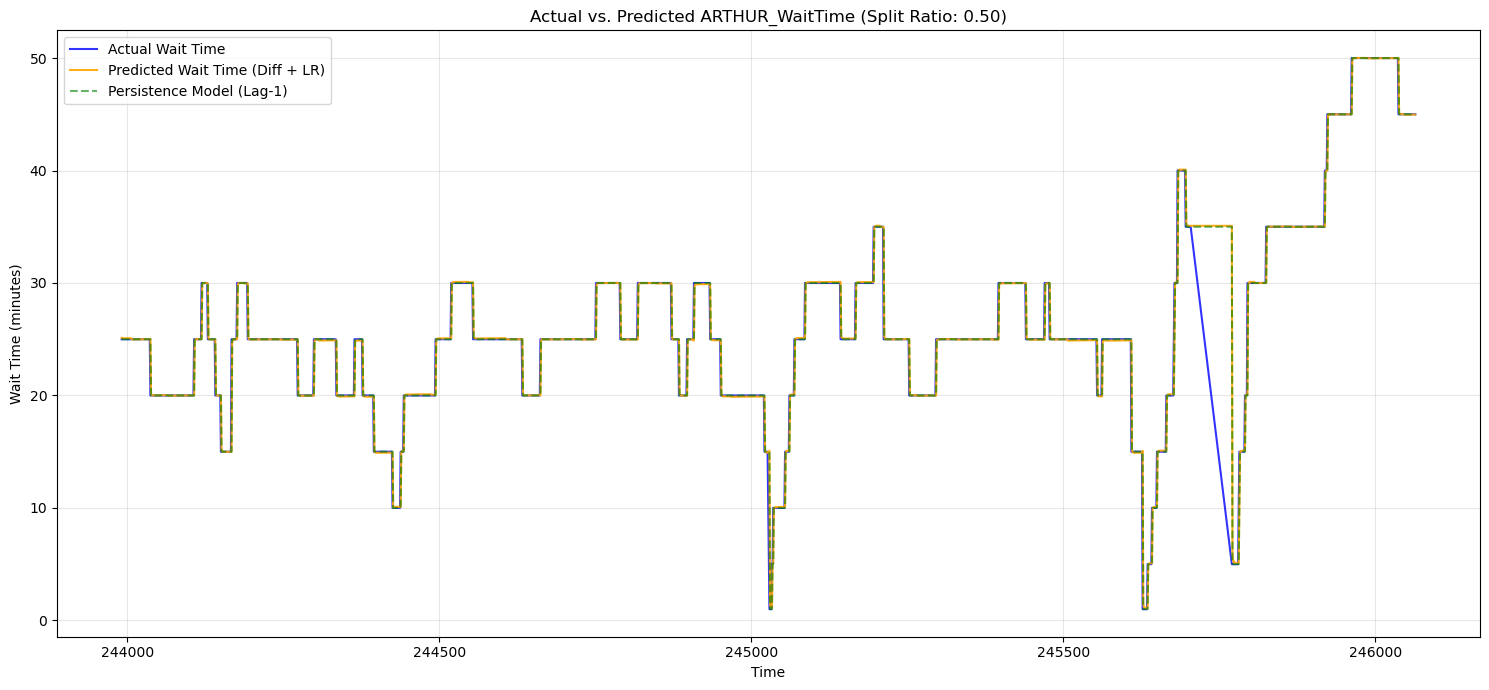

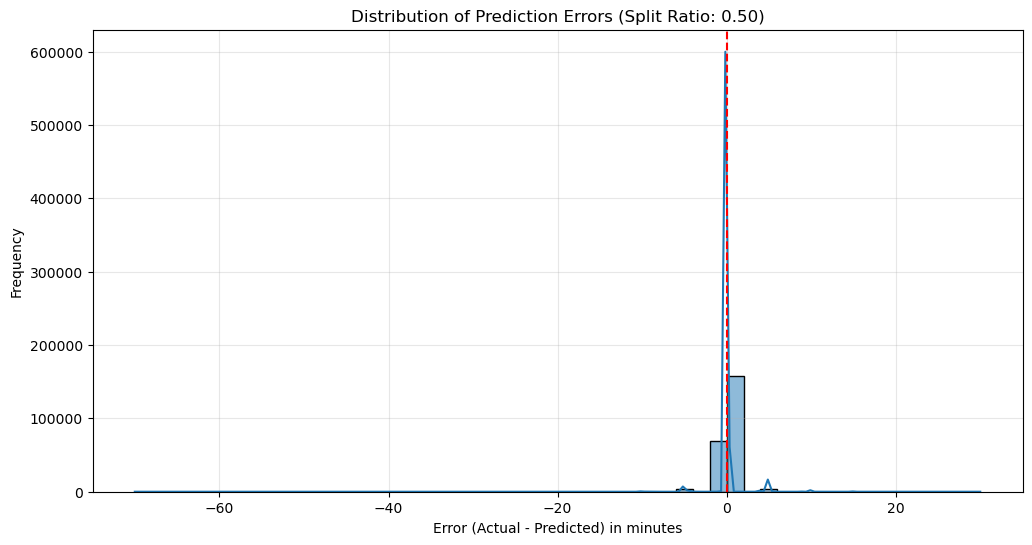


Error Statistics for split 0.50:
Mean error: 0.00 minutes
Standard deviation of error: 1.36 minutes
Median error: 0.01 minutes


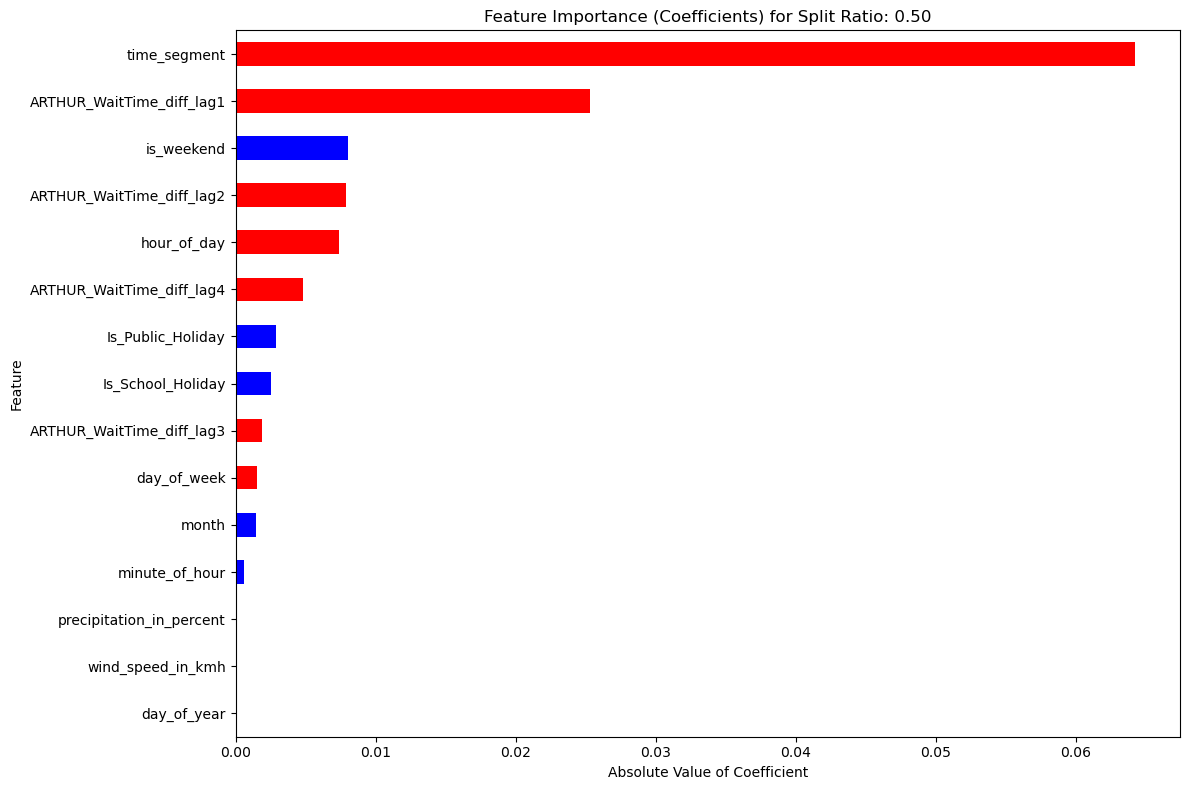


--- Running for training split ratio: 0.55 ---
Mean Absolute Error for Reconstructed Linear Regression: 0.29 minutes

Generating plots for this split...


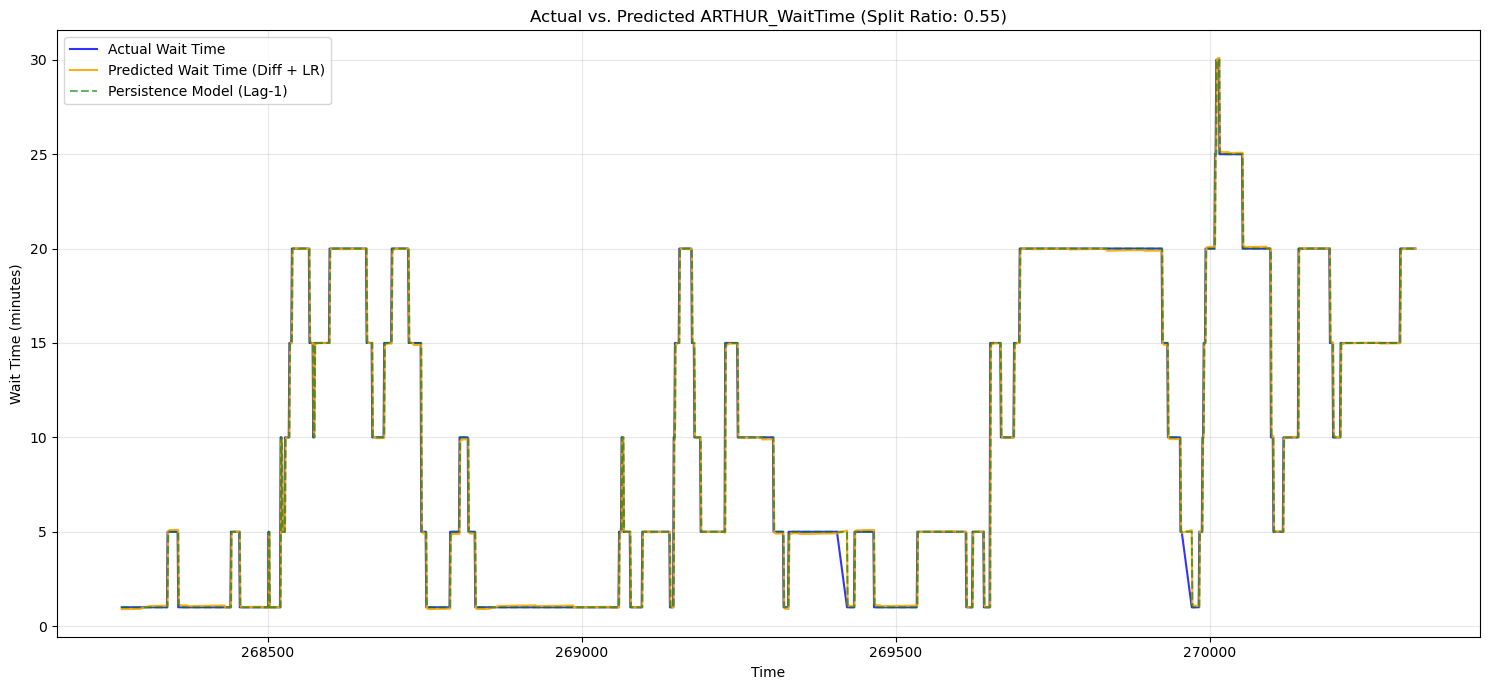

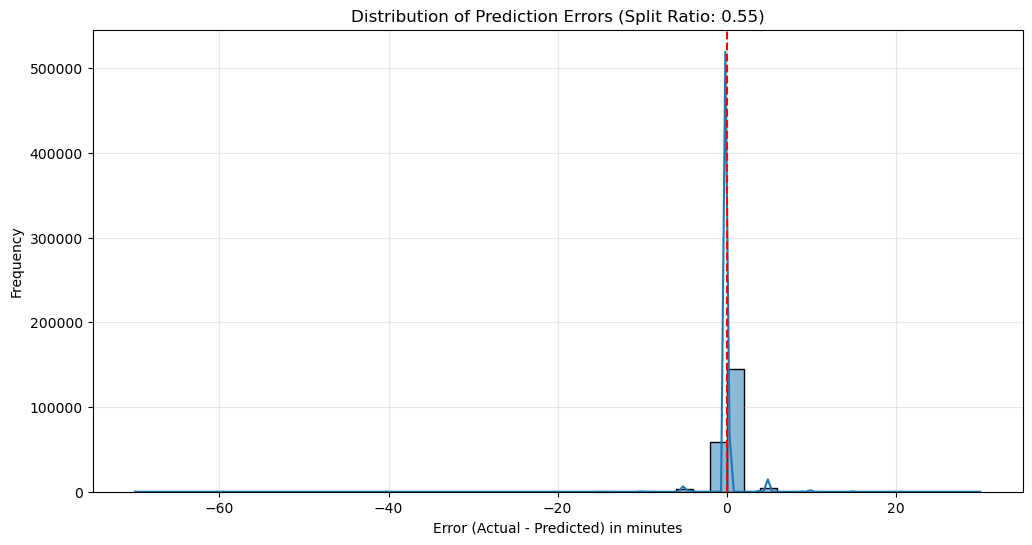


Error Statistics for split 0.55:
Mean error: 0.00 minutes
Standard deviation of error: 1.37 minutes
Median error: 0.01 minutes


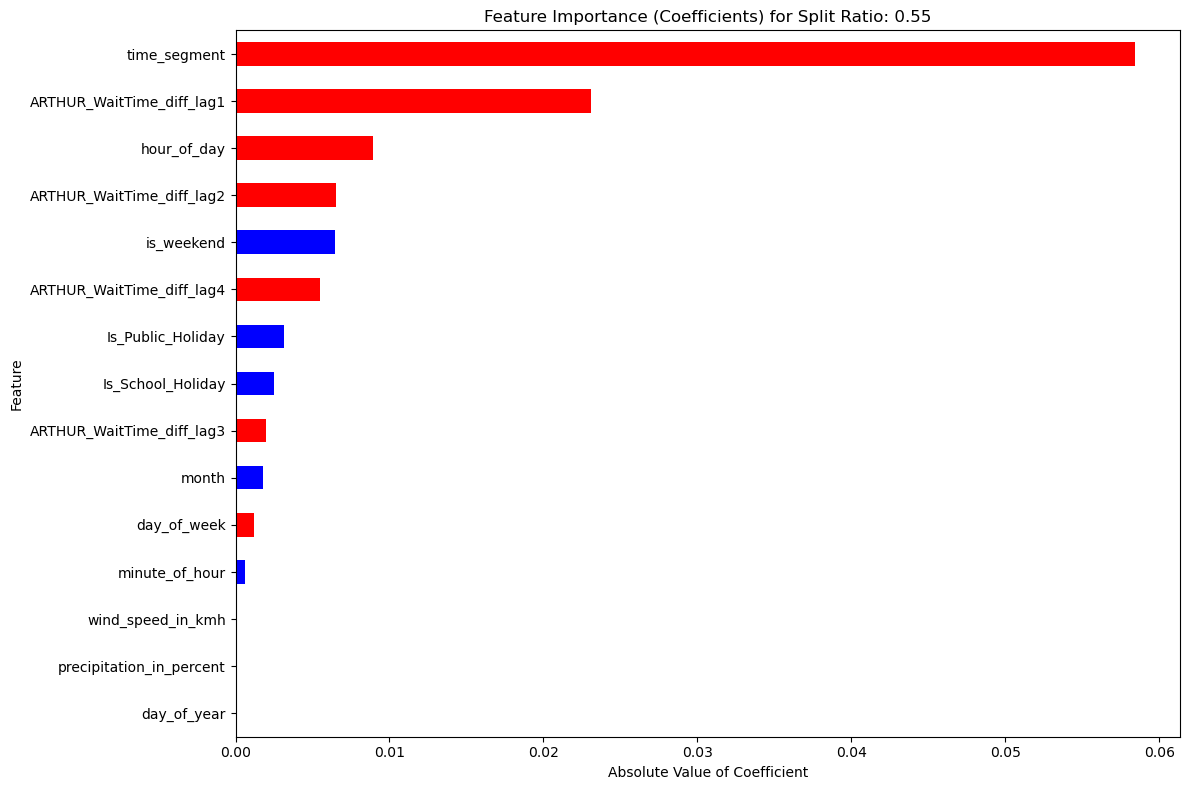


--- Running for training split ratio: 0.60 ---
Mean Absolute Error for Reconstructed Linear Regression: 0.30 minutes

Generating plots for this split...


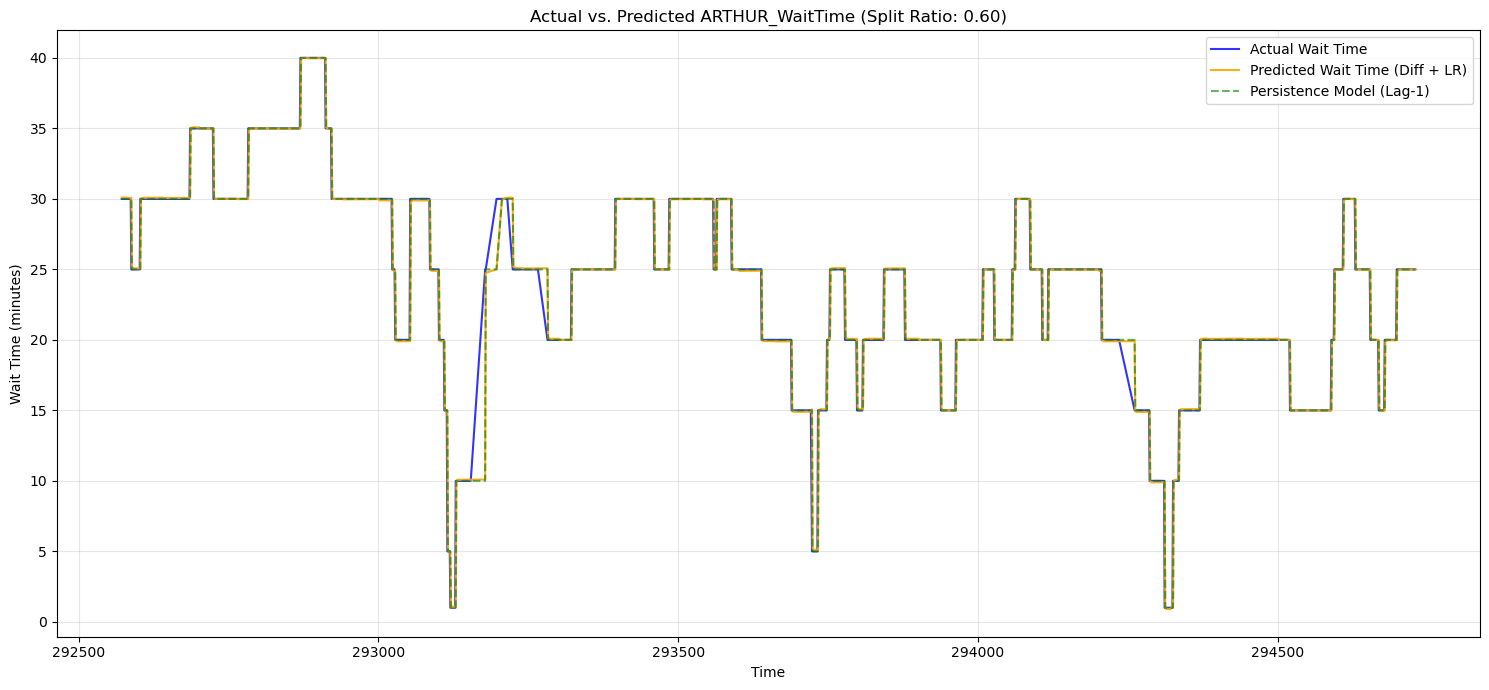

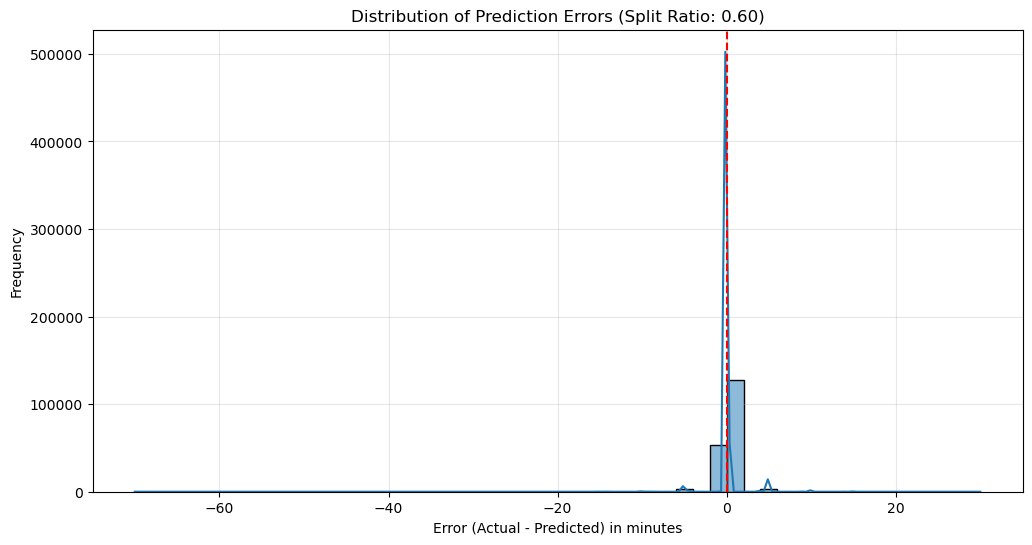


Error Statistics for split 0.60:
Mean error: 0.00 minutes
Standard deviation of error: 1.38 minutes
Median error: 0.01 minutes


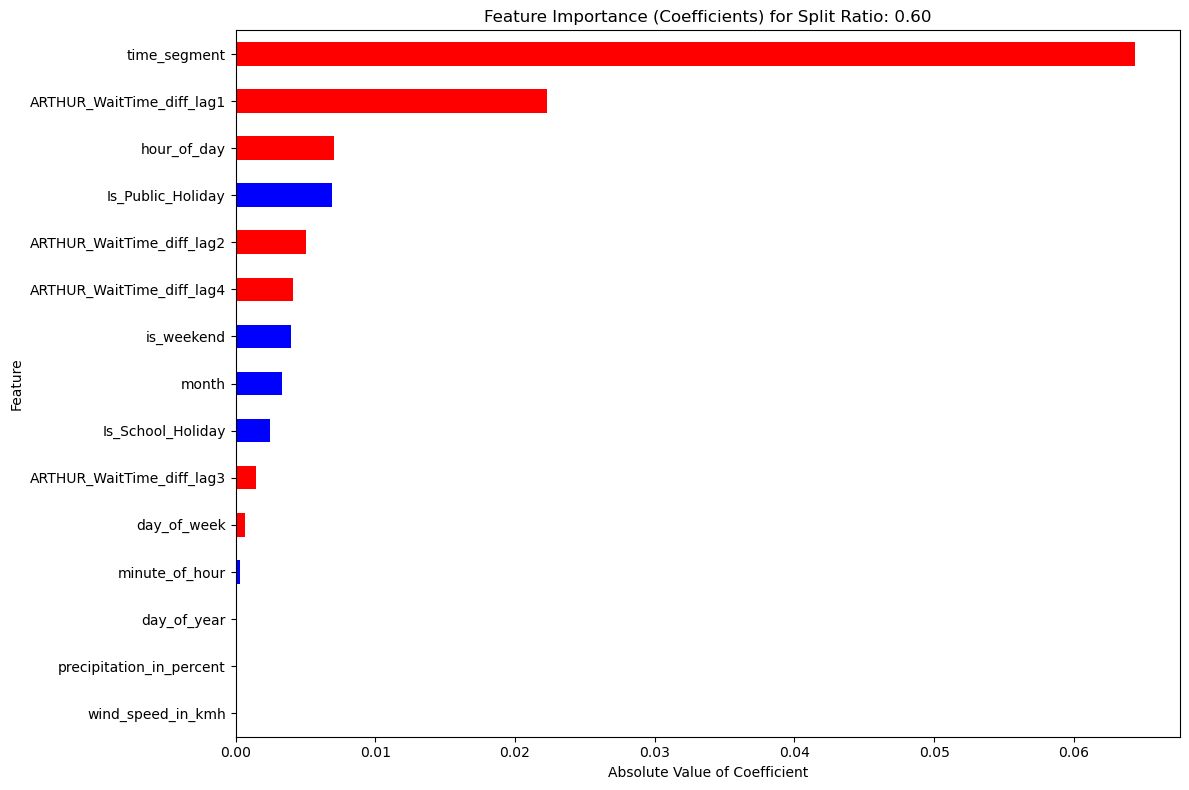


--- Running for training split ratio: 0.65 ---
Mean Absolute Error for Reconstructed Linear Regression: 0.30 minutes

Generating plots for this split...


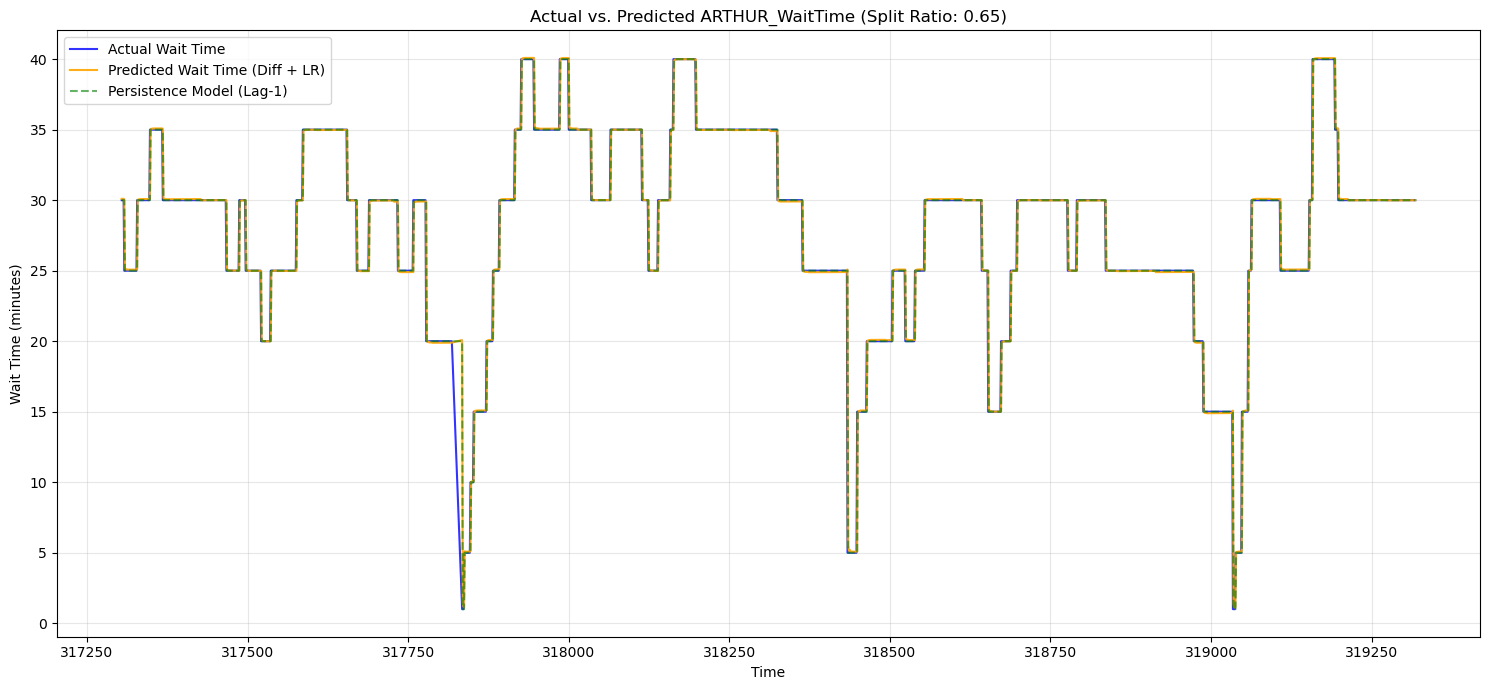

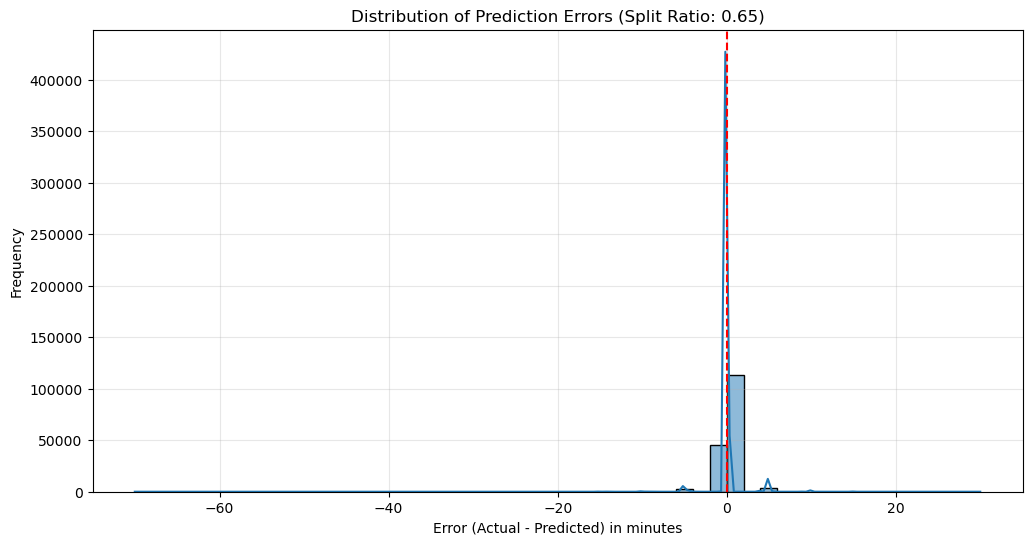


Error Statistics for split 0.65:
Mean error: 0.00 minutes
Standard deviation of error: 1.37 minutes
Median error: 0.01 minutes


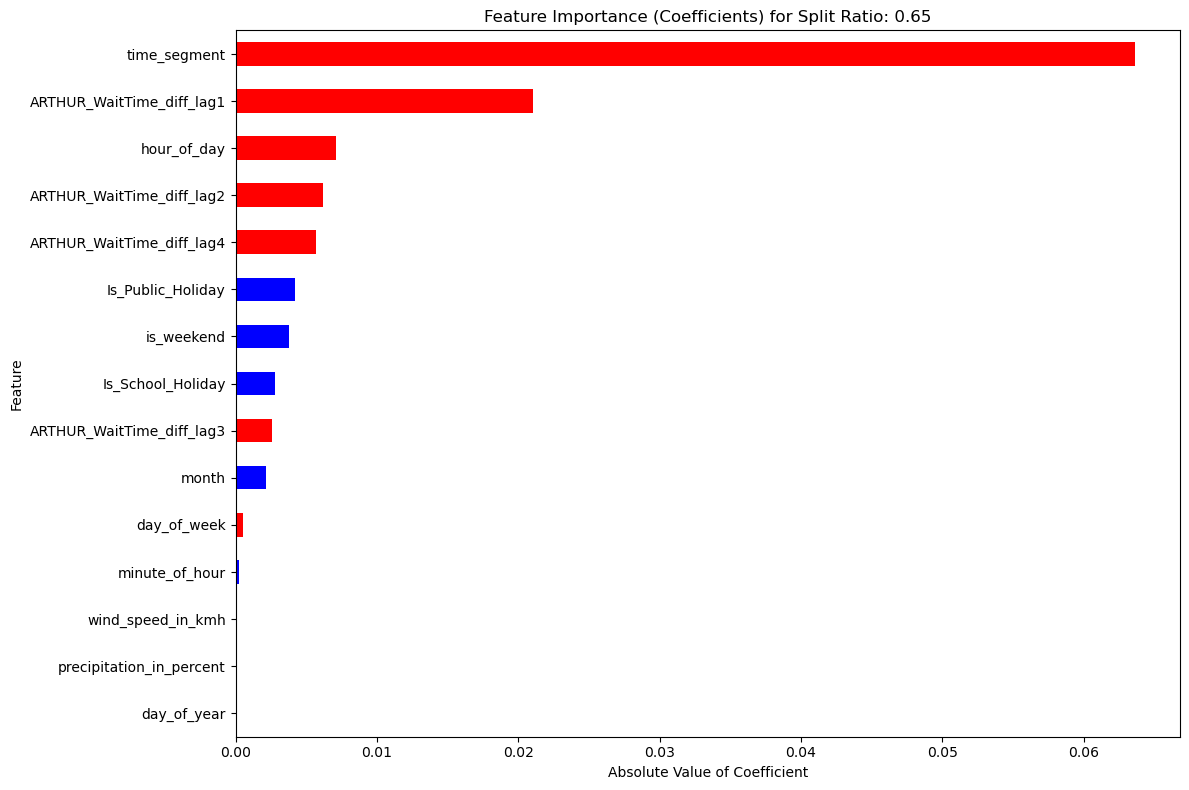


--- Running for training split ratio: 0.70 ---
Mean Absolute Error for Reconstructed Linear Regression: 0.30 minutes

Generating plots for this split...


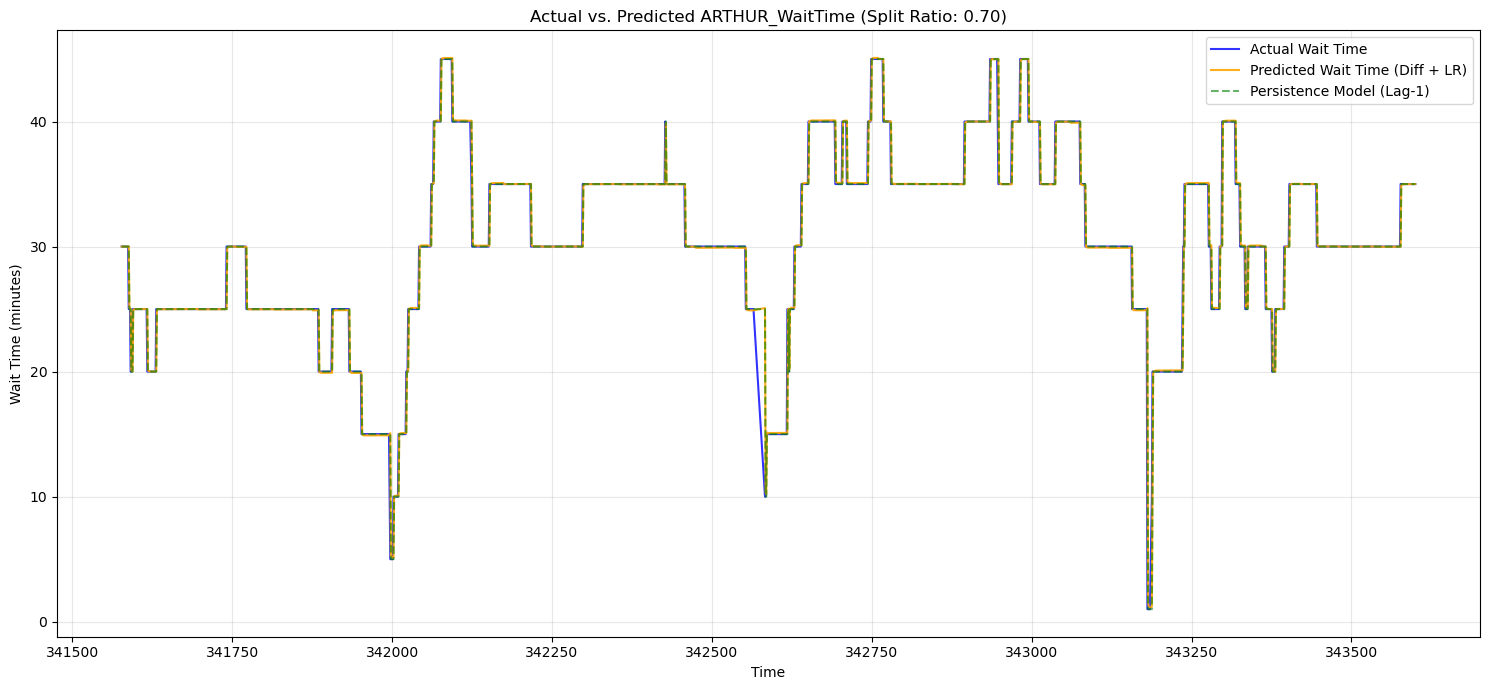

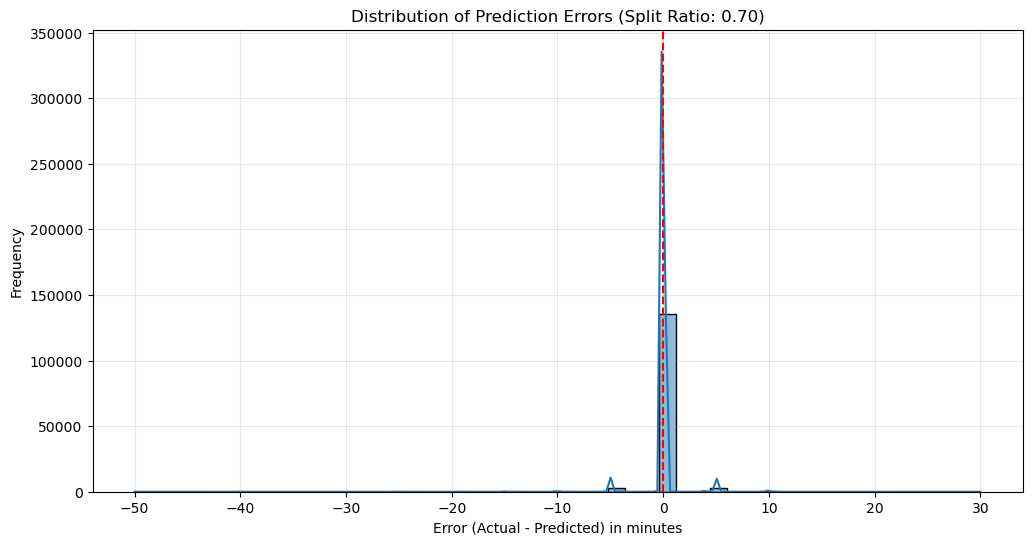


Error Statistics for split 0.70:
Mean error: 0.00 minutes
Standard deviation of error: 1.35 minutes
Median error: 0.00 minutes


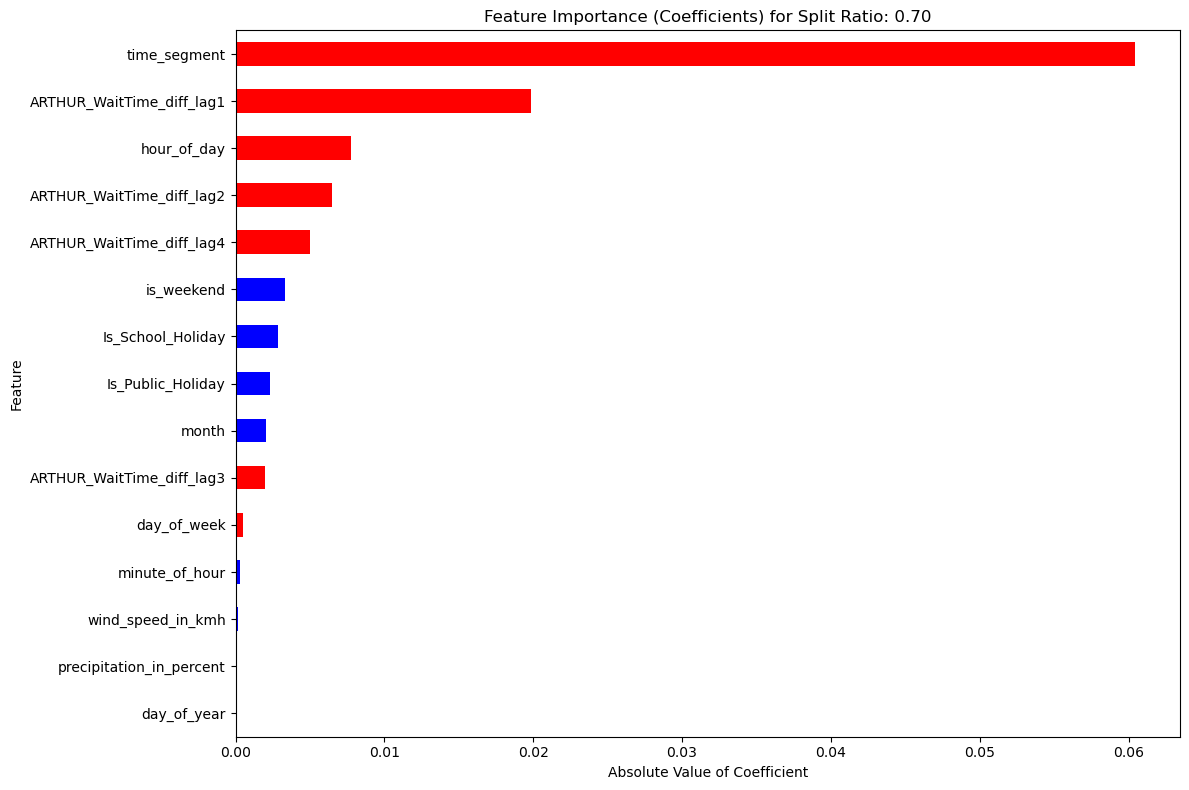


--- Running for training split ratio: 0.75 ---
Mean Absolute Error for Reconstructed Linear Regression: 0.30 minutes

Generating plots for this split...


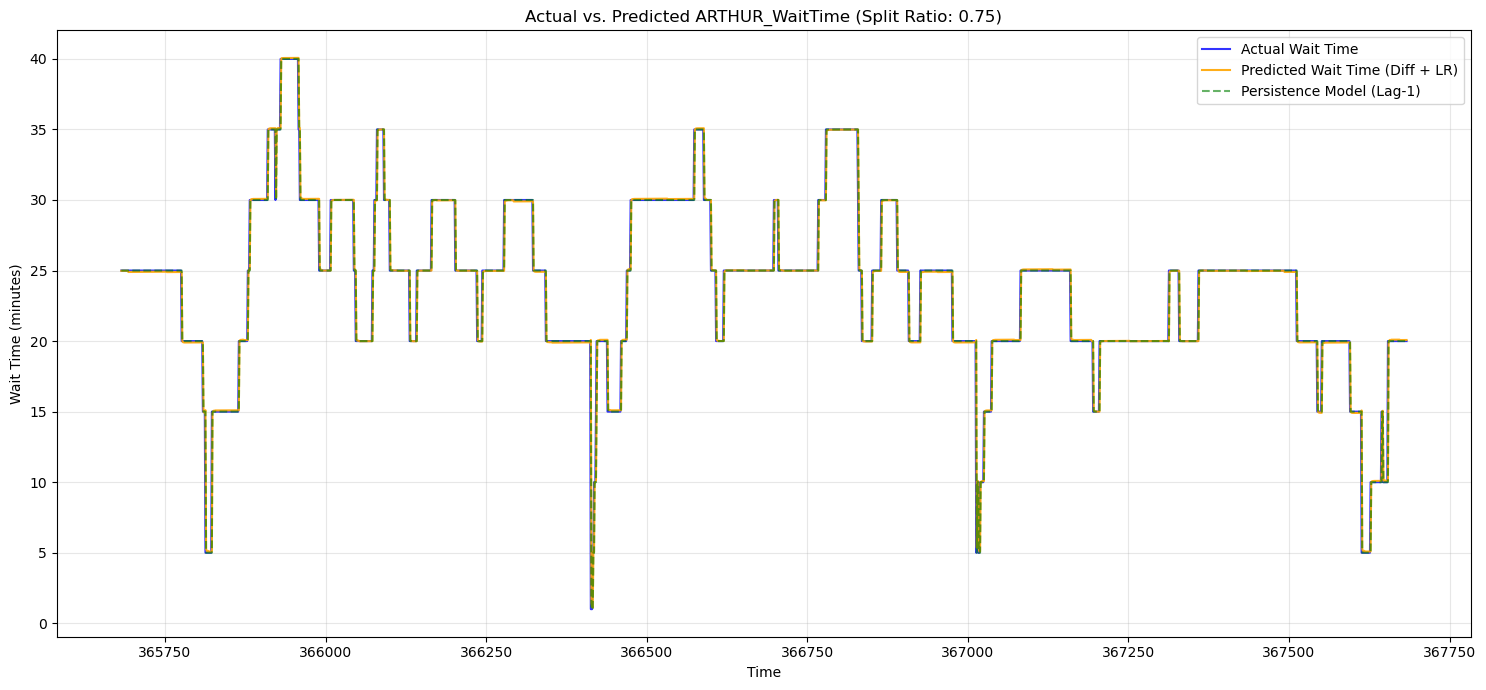

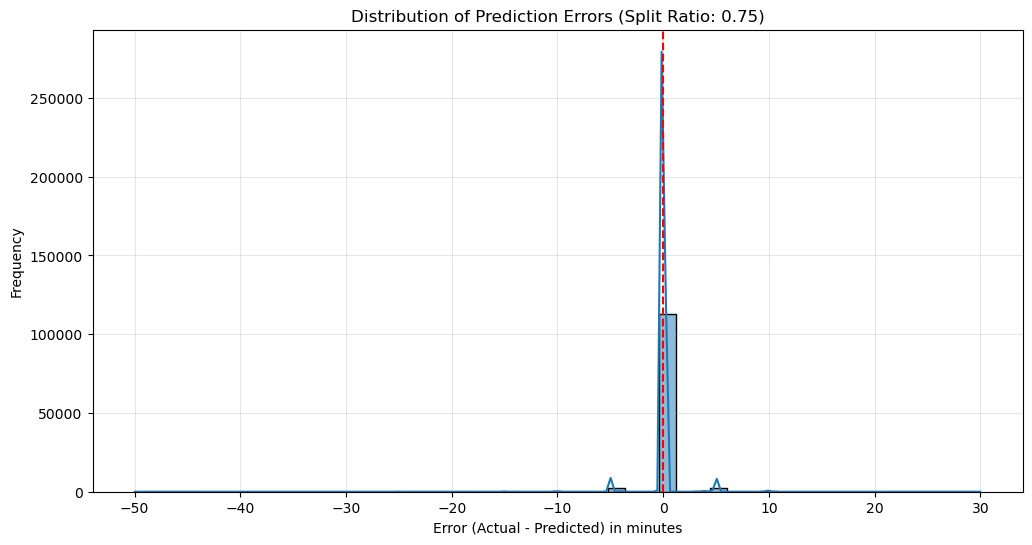


Error Statistics for split 0.75:
Mean error: 0.00 minutes
Standard deviation of error: 1.37 minutes
Median error: 0.00 minutes


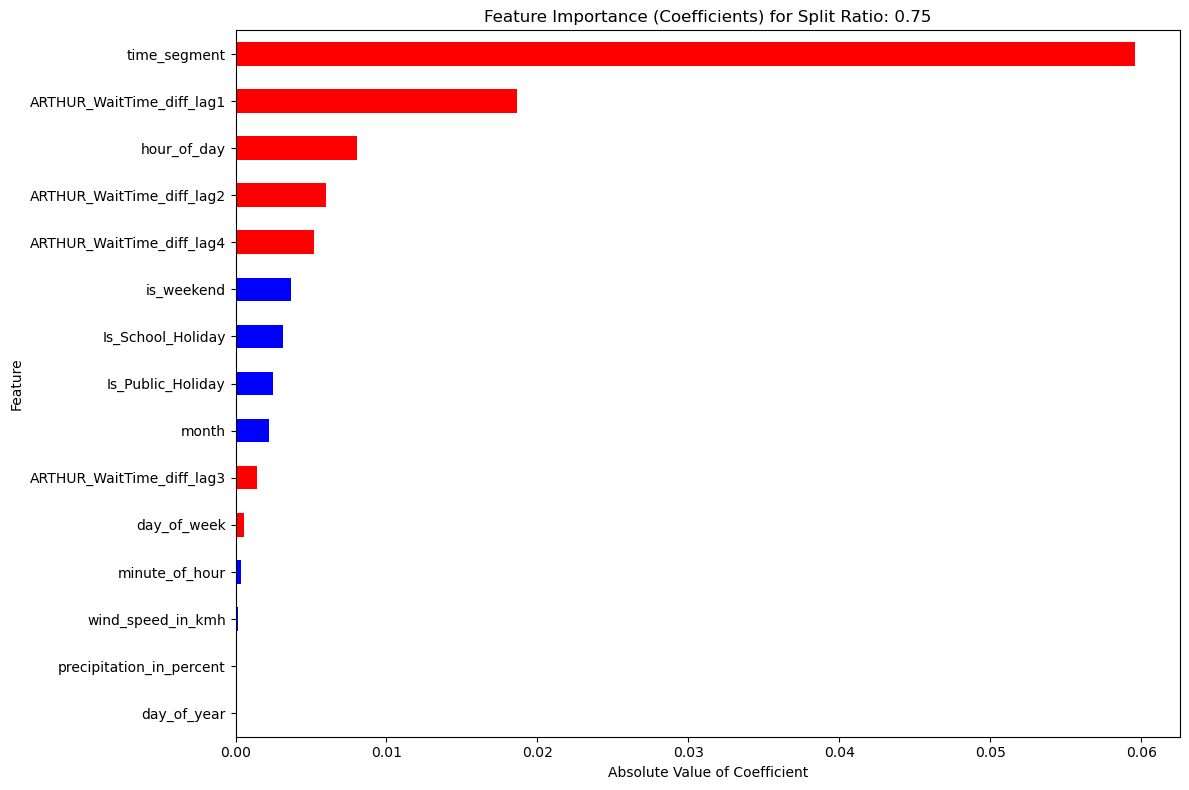


--- Running for training split ratio: 0.80 ---
Mean Absolute Error for Reconstructed Linear Regression: 0.30 minutes

Generating plots for this split...


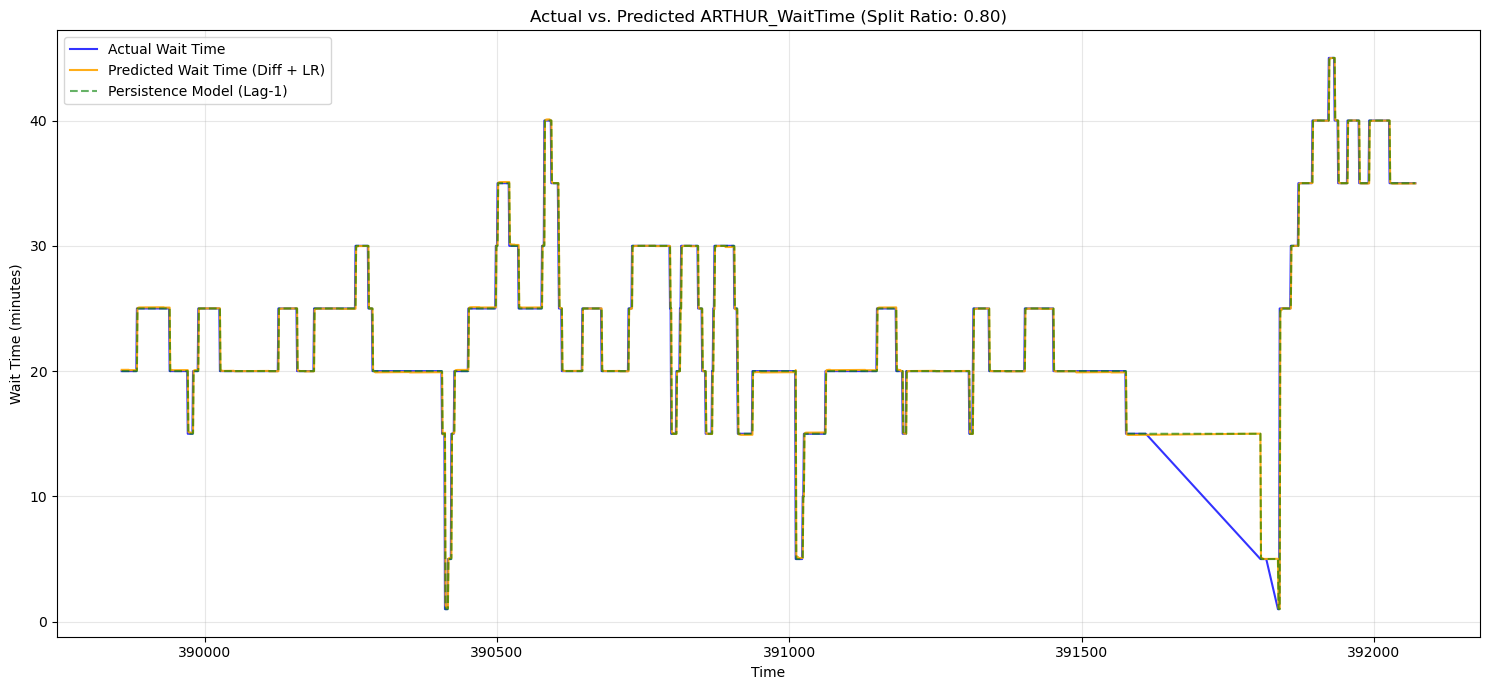

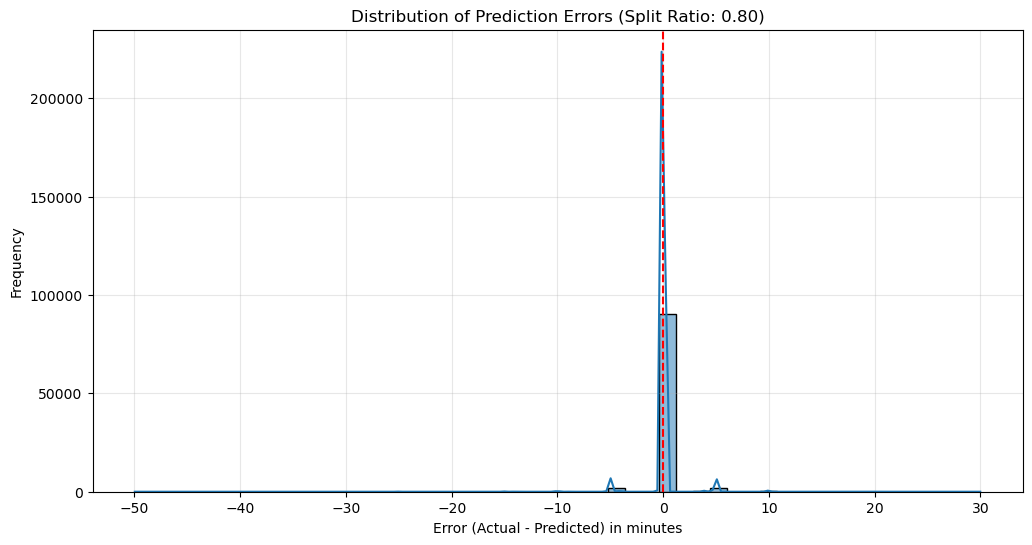


Error Statistics for split 0.80:
Mean error: 0.00 minutes
Standard deviation of error: 1.36 minutes
Median error: 0.01 minutes


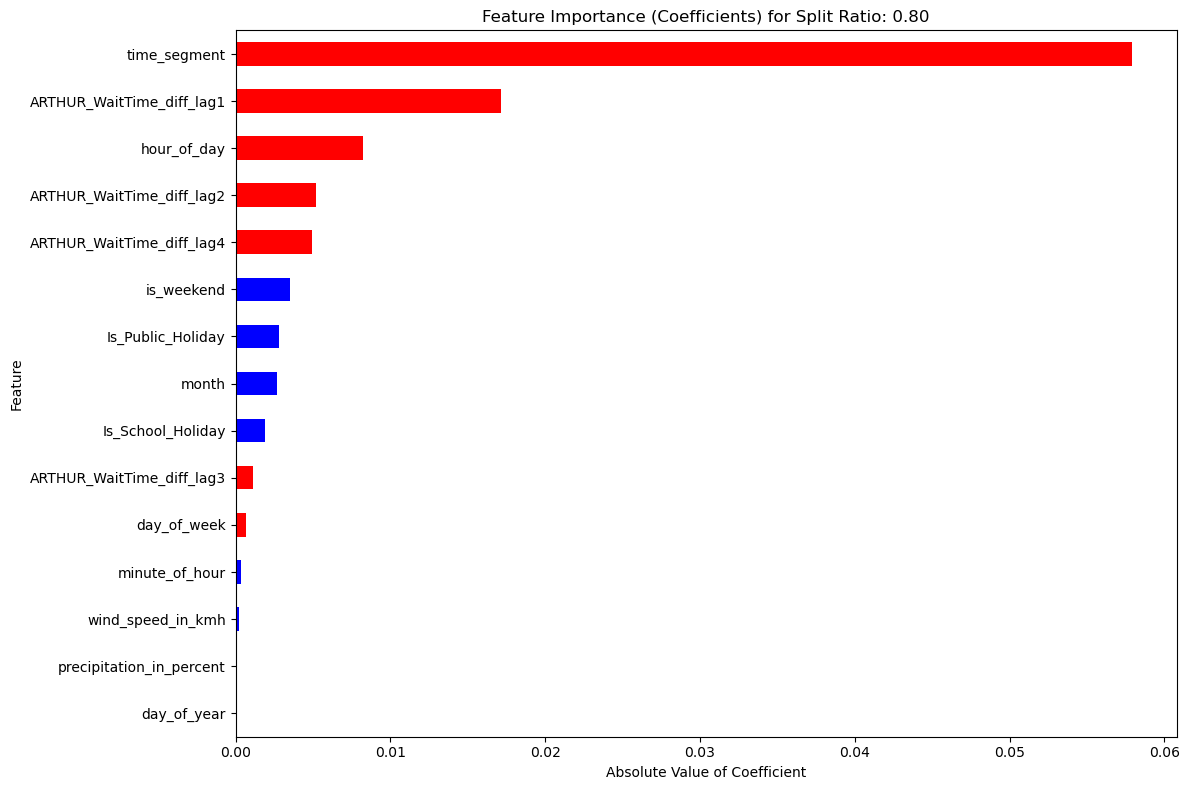

In [44]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# --- Assumed Setup ---
# The following variables must be defined in your environment before running this script:
#
# df_forecast: A pandas DataFrame that contains the columns listed below.
#
# X: A pandas DataFrame with your specified features.
#    X = df_forecast[['ARTHUR_WaitTime_diff_lag1', 'ARTHUR_WaitTime_diff_lag2', ...]]
#
# y: A pandas Series representing the target variable to be predicted, which is the difference.
#    y = df_forecast['ARTHUR_WaitTime_diff']
#
# target_column: A string with the name of the original, non-differenced column.
#    target_column = 'ARTHUR_WaitTime'
#
# The script relies on a column in `df_forecast` that holds the original, non-differenced
# lag-1 value for reconstruction. We assume its name is f'{target_column}_lag1_original'.
# For example: 'ARTHUR_WaitTime_lag1_original'
# ---

train_splits = np.arange(0.5, 0.81, 0.05) # Use 0.81 to ensure 0.80 is included
results_log = []

for split_ratio in train_splits:
    print(f"\n--- Running for training split ratio: {split_ratio:.2f} ---")

    # 1. Split data without shuffling to preserve time-series order
    test_ratio = 1 - split_ratio
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
    
    # Store test indices to correctly locate original values later
    test_indices = X_test.index

    # 2. Handle missing values using the mean of the training data
    train_mean = X_train.mean()
    X_train = X_train.fillna(train_mean)
    X_test = X_test.fillna(train_mean)

    # 3. Train the Linear Regression model
    # The model learns to predict the *difference* in wait times using the lagged difference features in X.
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    # Predict the differences for the test set
    y_pred_diff = lr_model.predict(X_test)

    # --- Model Performance Evaluation ---
    model_name = 'Linear Regression'
    
    # 4. Reconstruct Total Wait Time Predictions
    # Get the original lag-1 values (the previous time step's actual value) for the test set
    original_lag_column = f'{target_column}_lag1_original'
    original_lag1_test = df_forecast.loc[test_indices, original_lag_column]
    
    # Reconstruct the absolute wait times by adding the predicted difference to the previous value
    y_pred_reconstructed = original_lag1_test.values + y_pred_diff

    # 5. Calculate Model's Performance
    # Get the actual total wait times from the test set for comparison
    y_true = df_forecast.loc[test_indices, target_column].values
    
    # Calculate the Mean Absolute Error for the final, reconstructed predictions
    mae_reconstructed = mean_absolute_error(y_true, y_pred_reconstructed)
    print(f"Mean Absolute Error for Reconstructed {model_name}: {mae_reconstructed:.2f} minutes")

    # 6. Calculate Persistence Baseline MAE for comparison (not printed in the loop)
    # A persistence model predicts the next step will be the same as the last.
    mae_persistence = mean_absolute_error(y_true, original_lag1_test.values)
    
    # Calculate the percentage improvement over the simple persistence model
    improvement = (mae_persistence - mae_reconstructed) / mae_persistence * 100

    # 7. Log the comprehensive and corrected results
    results_log.append({
        'split_ratio': split_ratio,
        'model': model_name,
        'mae_reconstructed': mae_reconstructed,
        'mae_persistence': mae_persistence,
        'improvement_vs_persistence': improvement,
    })
# --- 8. Visualizations for this Split ---
    print("\nGenerating plots for this split...")
    
    # PLOT 1: Time-Series Comparison
    limit = 2000 # Limit plot to the first 2000 points for clarity
    test_indices_limited = test_indices[:limit]
    
    plt.figure(figsize=(15, 7))
    plt.plot(df_forecast.loc[test_indices_limited].index, y_true[:limit], label='Actual Wait Time', alpha=0.8, color='blue')
    plt.plot(df_forecast.loc[test_indices_limited].index, y_pred_reconstructed[:limit], 
             label='Predicted Wait Time (Diff + LR)', alpha=0.9, color='orange')
    plt.plot(df_forecast.loc[test_indices_limited].index, original_lag1_test[:limit], 
             label='Persistence Model (Lag-1)', alpha=0.6, linestyle='--', color='green')

    plt.title(f'Actual vs. Predicted {target_column} (Split Ratio: {split_ratio:.2f})')
    plt.xlabel('Time')
    plt.ylabel('Wait Time (minutes)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # PLOT 2: Distribution of Prediction Errors
    plt.figure(figsize=(12, 6))
    errors = y_true - y_pred_reconstructed
    sns.histplot(errors, kde=True, bins=50)
    plt.title(f'Distribution of Prediction Errors (Split Ratio: {split_ratio:.2f})')
    plt.xlabel(f'Error (Actual - Predicted) in minutes')
    plt.ylabel('Frequency')
    plt.axvline(x=0, color='r', linestyle='--')
    plt.grid(True, alpha=0.3)
    plt.show()

    print(f"\nError Statistics for split {split_ratio:.2f}:")
    print(f"Mean error: {np.mean(errors):.2f} minutes")
    print(f"Standard deviation of error: {np.std(errors):.2f} minutes")
    print(f"Median error: {np.median(errors):.2f} minutes")

    # PLOT 3: Feature Importance
    plt.figure(figsize=(12, 8))
    importances = pd.Series(lr_model.coef_, index=X_train.columns)
    # Plot absolute values for magnitude, but keep original for color
    sorted_importances = importances.abs().sort_values()
    colors = ['red' if c < 0 else 'blue' for c in importances[sorted_importances.index]]

    sorted_importances.plot(kind='barh', color=colors)
    plt.title(f'Feature Importance (Coefficients) for Split Ratio: {split_ratio:.2f}')
    plt.xlabel('Absolute Value of Coefficient')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()



In [45]:
import seaborn as sns

In [46]:
 #Display the final results in a clean DataFrame
results_df = pd.DataFrame(results_log)
print("\n--- Final Results Summary ---")
print(results_df)


--- Final Results Summary ---
   split_ratio              model  mae_reconstructed  mae_persistence  \
0         0.50  Linear Regression           0.292068         0.241344   
1         0.55  Linear Regression           0.294476         0.243616   
2         0.60  Linear Regression           0.295106         0.246800   
3         0.65  Linear Regression           0.296397         0.248540   
4         0.70  Linear Regression           0.298203         0.250733   
5         0.75  Linear Regression           0.302112         0.254641   
6         0.80  Linear Regression           0.298413         0.252052   

   improvement_vs_persistence  
0                  -21.017600  
1                  -20.877405  
2                  -19.573093  
3                  -19.255161  
4                  -18.932659  
5                  -18.642241  
6                  -18.393550  


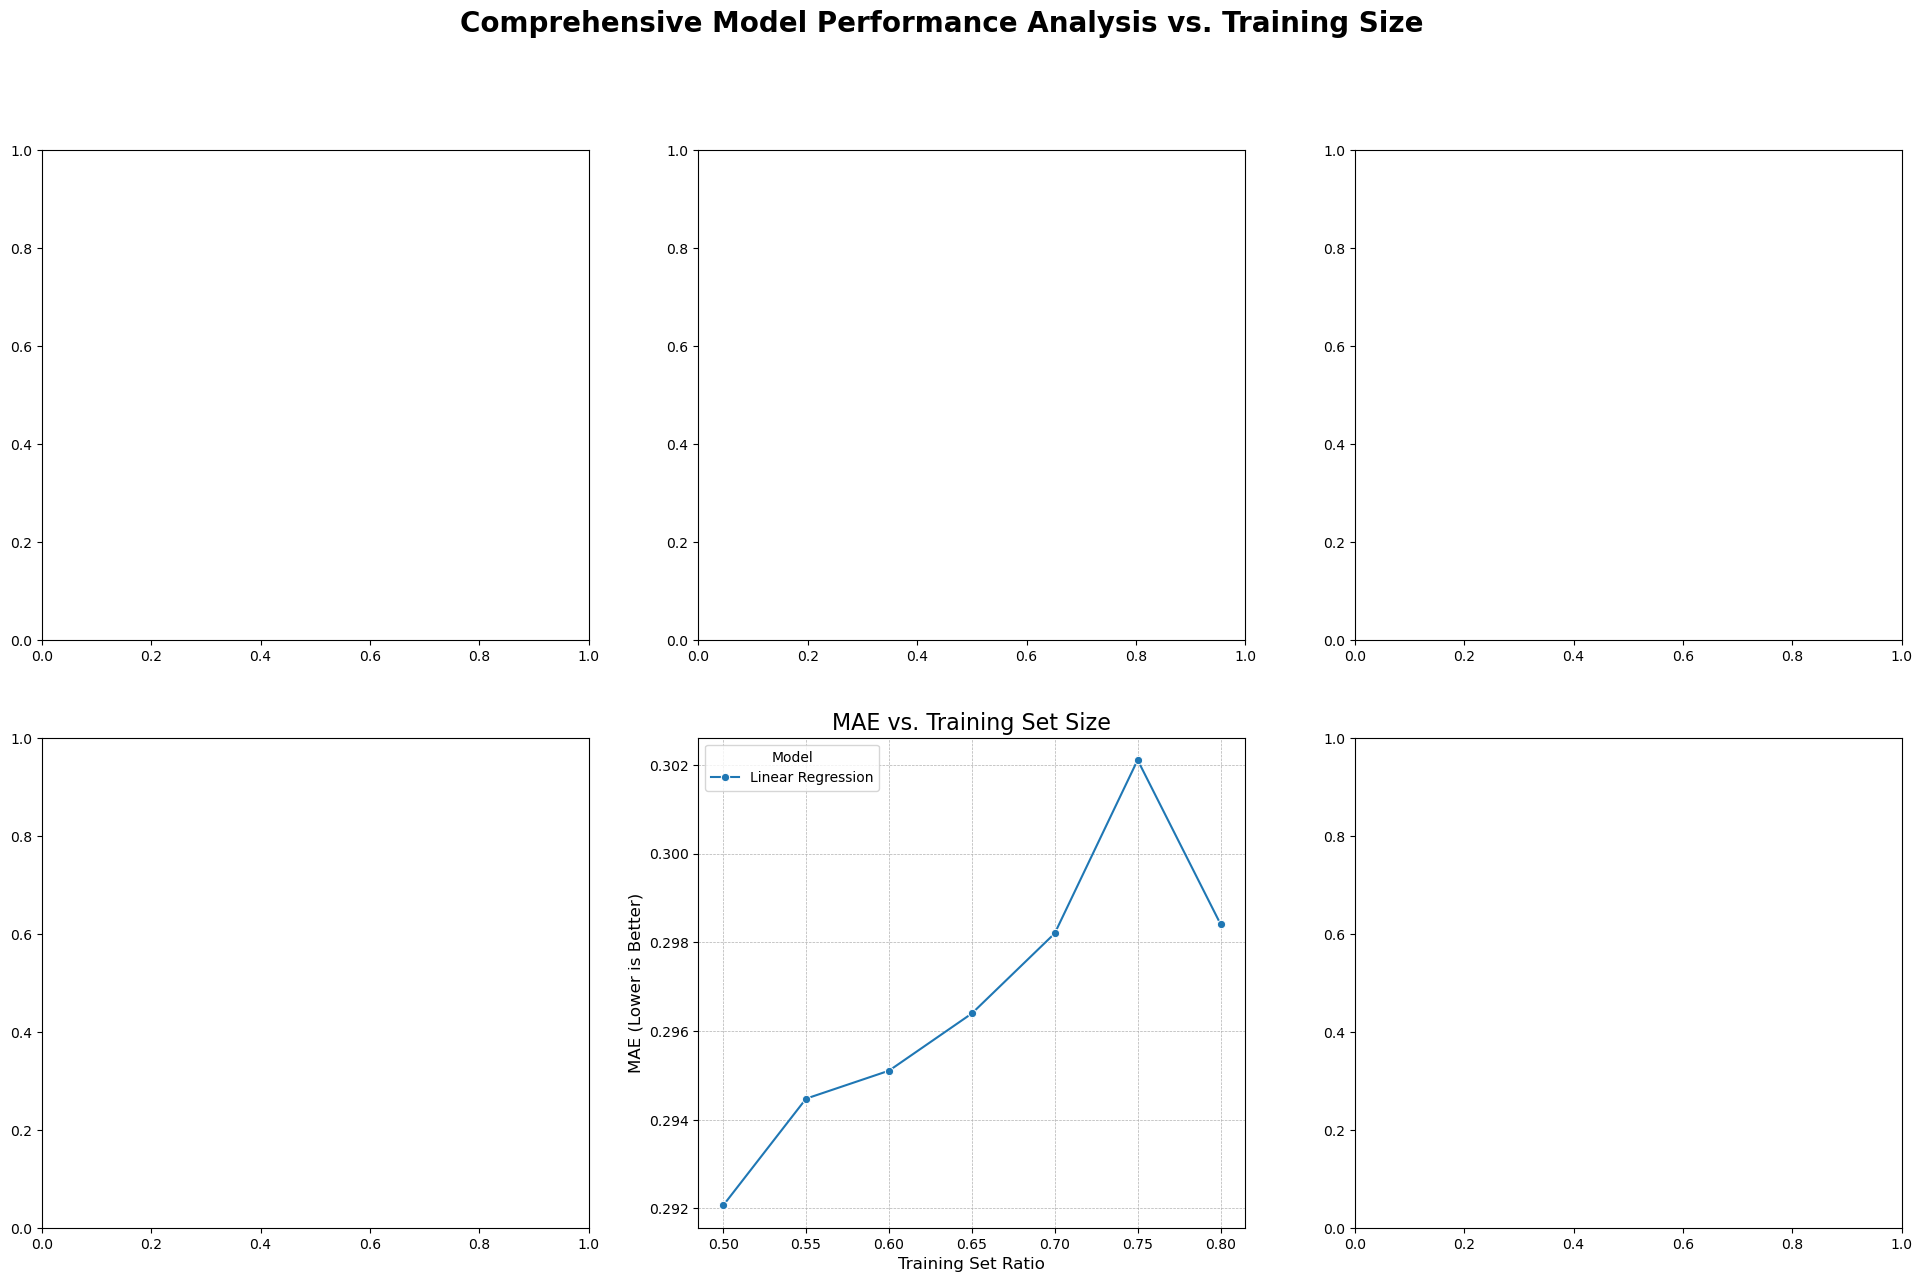

In [47]:
# --- Create a 2x3 grid of subplots for a comprehensive view ---
fig, axes = plt.subplots(2, 3, figsize=(24, 14))
fig.suptitle('Comprehensive Model Performance Analysis vs. Training Size', fontsize=20, fontweight='bold')

# --- Plot 5: Mean Absolute Error (MAE) (NEW) ---
sns.lineplot(data=results_df, x='split_ratio', y='mae_reconstructed', hue='model', marker='o', ax=axes[1, 1])
axes[1, 1].set_title('MAE vs. Training Set Size', fontsize=16)
axes[1, 1].set_xlabel('Training Set Ratio', fontsize=12)
axes[1, 1].set_ylabel('MAE (Lower is Better)', fontsize=12)
axes[1, 1].legend(title='Model')
axes[1, 1].grid(True, which='both', linestyle='--', linewidth=0.5)

In [48]:
log = []
# 1. Split data without shuffling to preserve time-series order
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

# Store test indices to correctly locate original values later
test_indices = X_test.index

# 2. Handle missing values using the mean of the training data
train_mean = X_train.mean()
X_train = X_train.fillna(train_mean)
X_test = X_test.fillna(train_mean)

# 3. Train the Linear Regression model
# The model learns to predict the *difference* in wait times using the lagged difference features in X.
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict the differences for the test set
y_pred_diff = lr_model.predict(X_test)

# --- Model Performance Evaluation ---
model_name = 'Linear Regression'

# 4. Reconstruct Total Wait Time Predictions
# Get the original lag-1 values (the previous time step's actual value) for the test set
original_lag_column = f'{target_column}_lag1_original'
original_lag1_test = df_forecast.loc[test_indices, original_lag_column]

# Reconstruct the absolute wait times by adding the predicted difference to the previous value
y_pred_reconstructed = original_lag1_test.values + y_pred_diff

# 5. Calculate Model's Performance
# Get the actual total wait times from the test set for comparison
y_true = df_forecast.loc[test_indices, target_column].values

# Calculate the Mean Absolute Error for the final, reconstructed predictions
mae_reconstructed = mean_absolute_error(y_true, y_pred_reconstructed)

# 6. Calculate Persistence Baseline MAE for comparison (not printed in the loop)
# A persistence model predicts the next step will be the same as the last.
mae_persistence = mean_absolute_error(y_true, original_lag1_test.values)

# Calculate the percentage improvement over the simple persistence model
improvement = (mae_persistence - mae_reconstructed) / mae_persistence * 100

# 7. Log the comprehensive and corrected results
log.append({
    'split_ratio': split_ratio,
    'model': model_name,
    'mae_reconstructed': mae_reconstructed,
    'mae_persistence': mae_persistence,
    'improvement_vs_persistence': improvement,
})

In [49]:
log

[{'split_ratio': 0.8000000000000003,
  'model': 'Linear Regression',
  'mae_reconstructed': 0.2951064925489675,
  'mae_persistence': 0.24680008261267894,
  'improvement_vs_persistence': -19.57309309823014}]

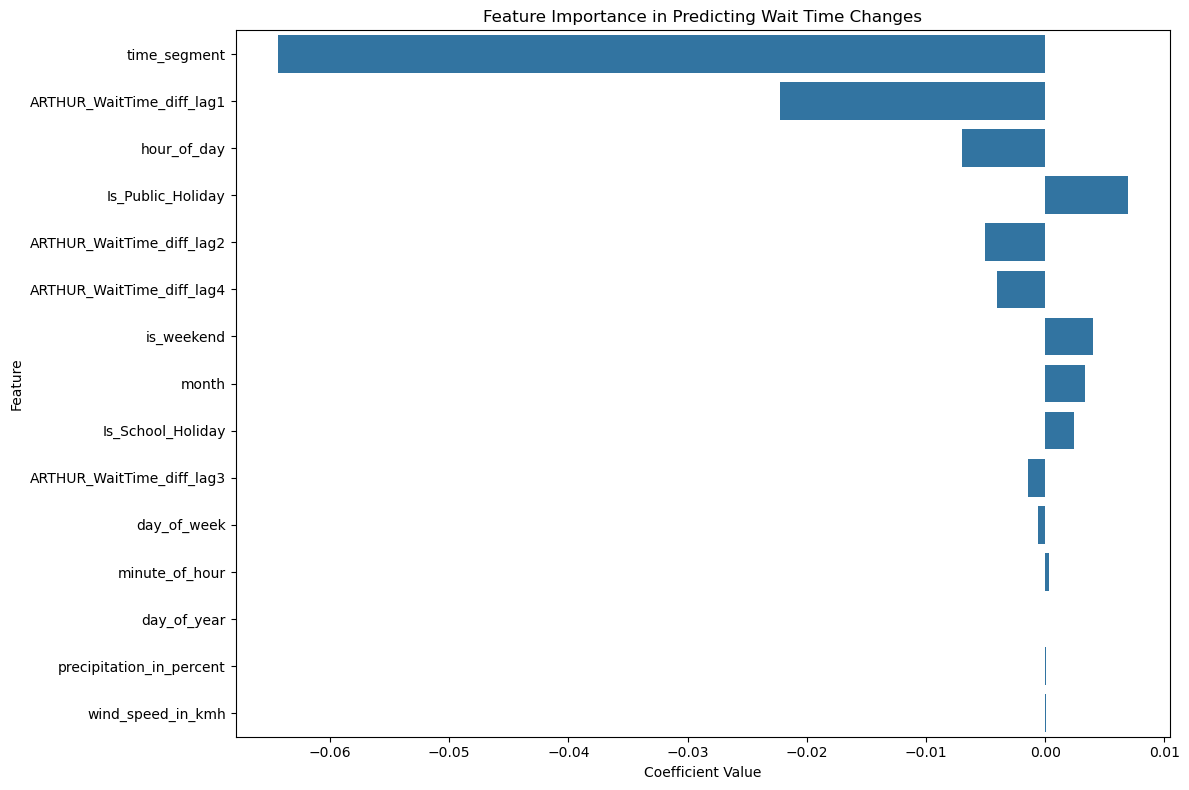

Top 5 most important features:
                      Feature  Importance
10               time_segment   -0.064369
0   ARTHUR_WaitTime_diff_lag1   -0.022270
4                 hour_of_day   -0.007016
12          Is_Public_Holiday    0.006912
1   ARTHUR_WaitTime_diff_lag2   -0.005048


In [50]:
# Feature Importance Analysis
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': lr_model.coef_
})

feature_importance = feature_importance.sort_values('Importance', key=abs, ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance in Predicting Wait Time Changes')
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.show()

print("Top 5 most important features:")
print(feature_importance.head(5))